##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image segmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial focuses on the task of image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?

In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image—this task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to name a few.

This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

- Class 1: Pixel belonging to the pet.
- Class 2: Pixel bordering the pet.
- Class 3: None of the above/a surrounding pixel.

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmpfs/tmp/pip-req-build-bm5eh4y7
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmpfs/tmp/pip-req-build-bm5eh4y7


  Resolved https://github.com/tensorflow/examples.git to commit 0b14ce1c88537b94772cc99d995d936417be6f5d


  Preparing metadata (setup.py) ... -

 done


 \

 done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1699471818.63262868223049538191520590201343318150499692381-py3-none-any.whl size=301553 sha256=ff22bf59e8d863f7de99c737ef497d167d9c014d591001a7c40b0112ca9ccd4f
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-ca0a7h0r/wheels/08/f6/82/53a5b86c72bceebba962022c76037c95a9b2912f0719e5b9d2
Successfully built tensorflow-examples


In [3]:
import tensorflow as tf

import tensorflow_datasets as tfds

2023-12-07 02:29:39.545385: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 02:29:39.545438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 02:29:39.547072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Download the Oxford-IIIT Pets dataset

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

 In addition, the image color values are normalized to the `[0, 1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits:

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image.
Go to the [Image augmentation](data_augmentation.ipynb) tutorial to learn more.


In [10]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs:

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset:

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


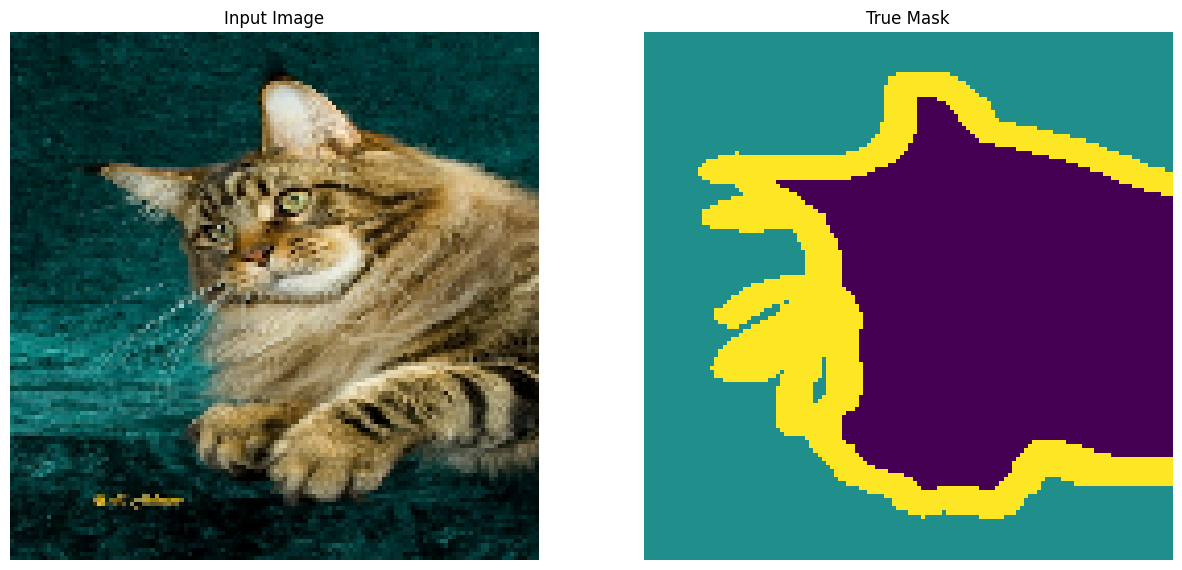

2023-12-07 02:29:48.313611: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


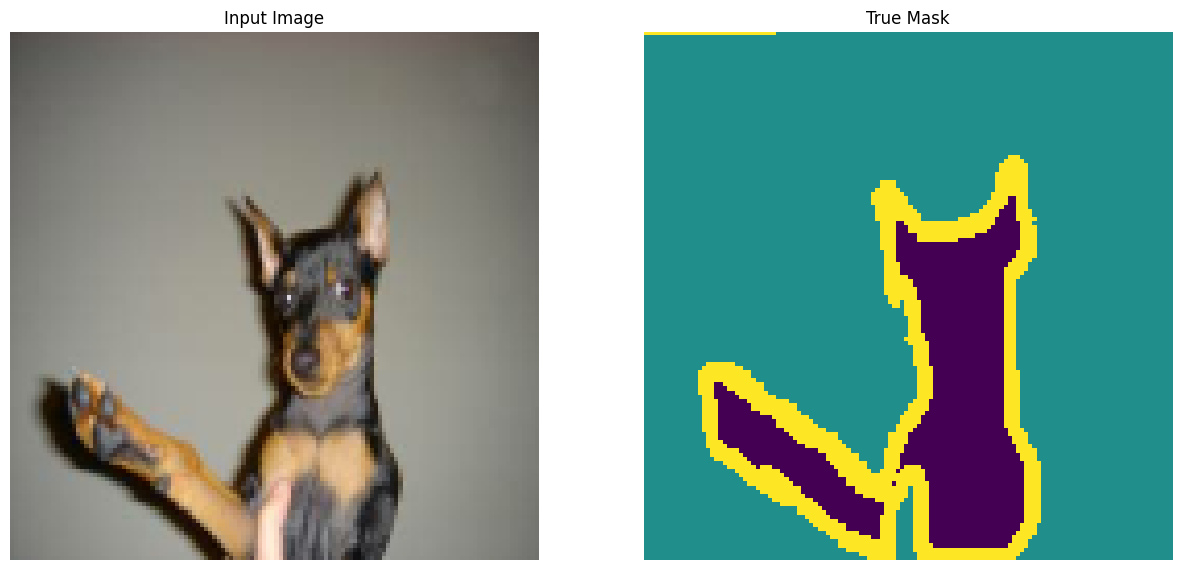

In [13]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)


As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

   8192/9406464 [..............................] - ETA: 0s

9306112/9406464 [============================>.] - ETA: 0s

9406464/9406464 [==============================] - 0s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model. 

Since this is a multiclass classification problem, use the `tf.keras.losses.SparseCategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [17]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Plot the resulting model architecture:

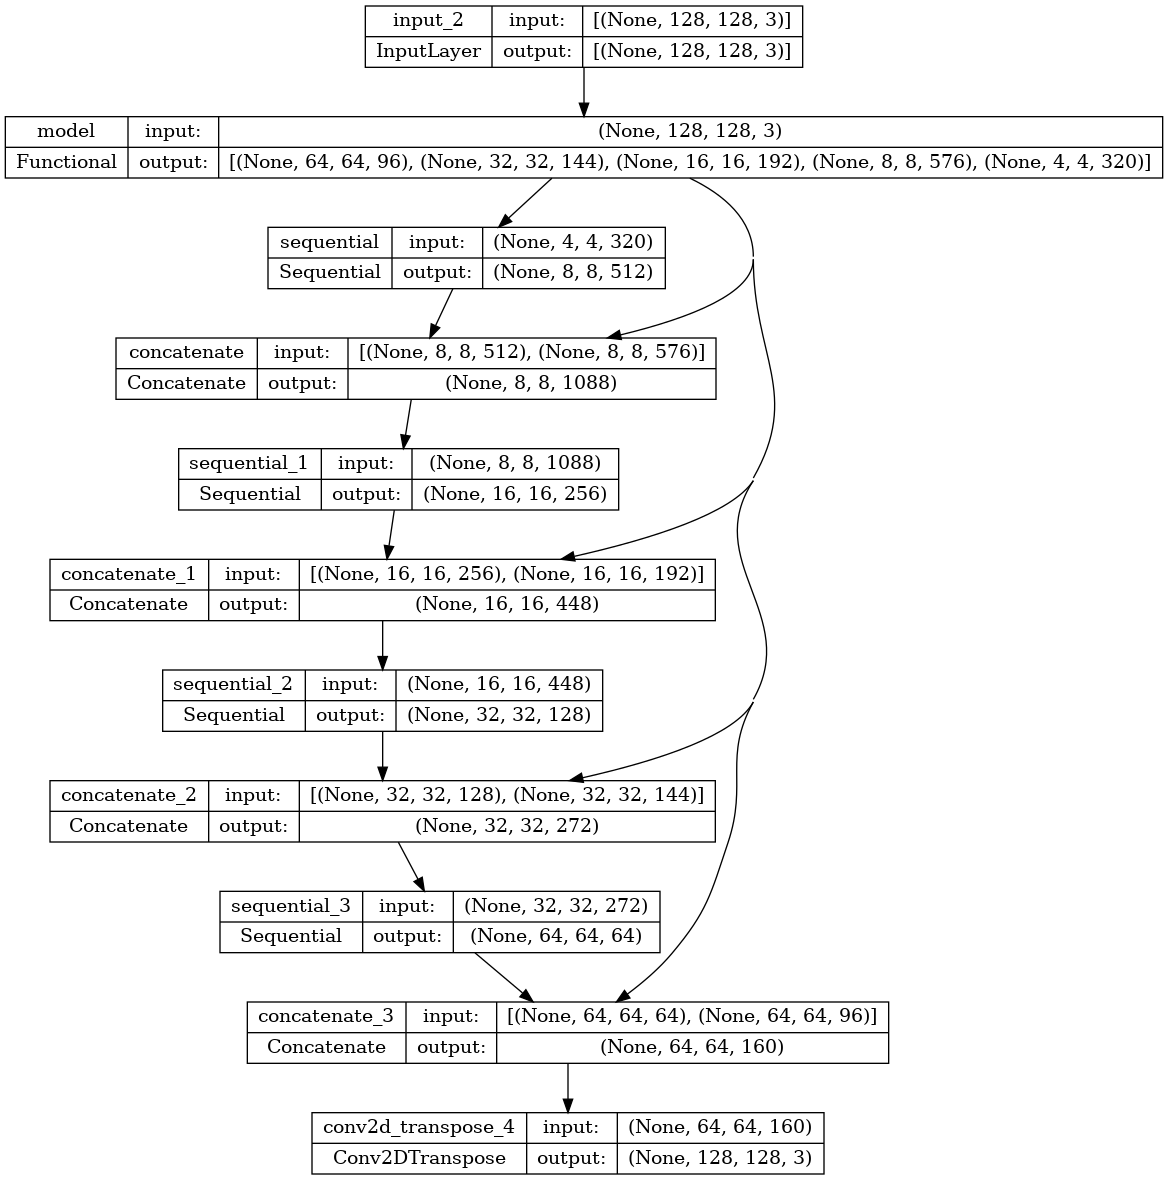

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training:

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 3s 3s/step


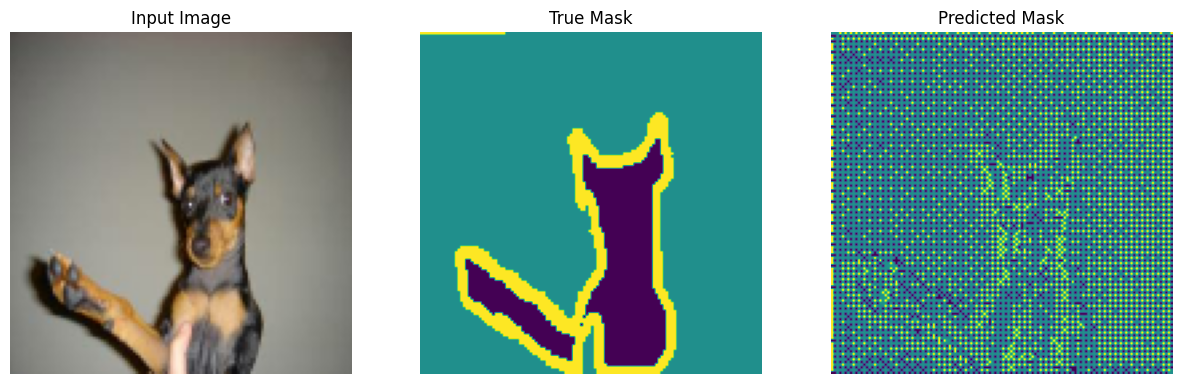

In [21]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training:

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 47ms/step


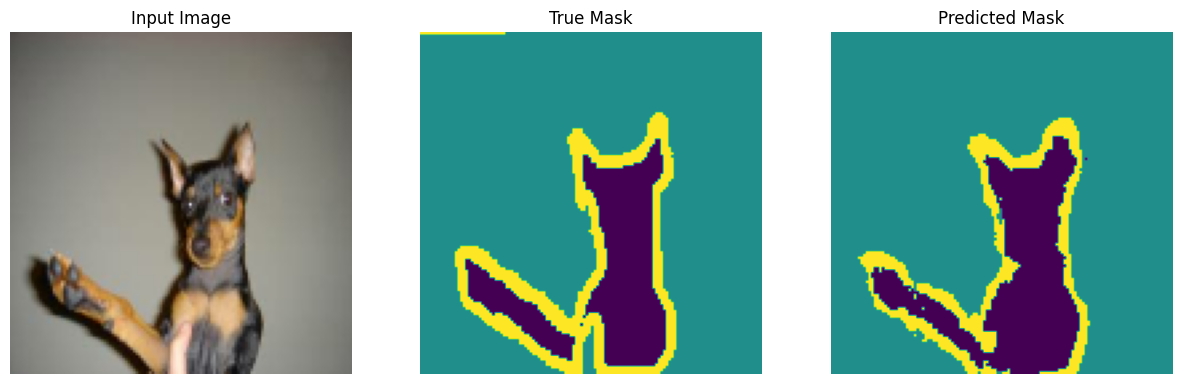


Sample Prediction after epoch 20

57/57 [==============================] - 8s 144ms/step - loss: 0.1740 - accuracy: 0.9290 - val_loss: 0.2727 - val_accuracy: 0.9045


In [23]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

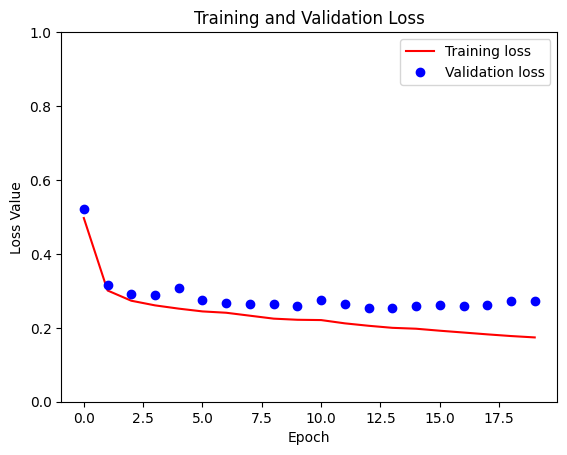

In [24]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 27ms/step


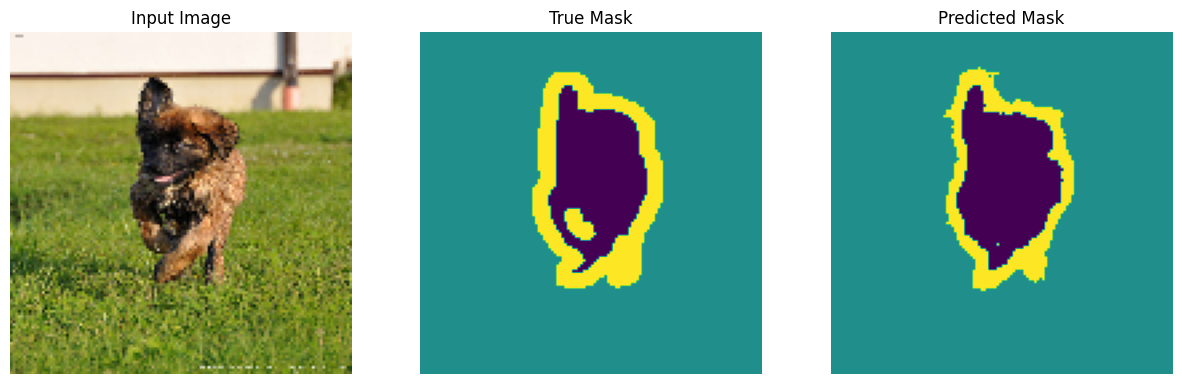

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 26ms/step


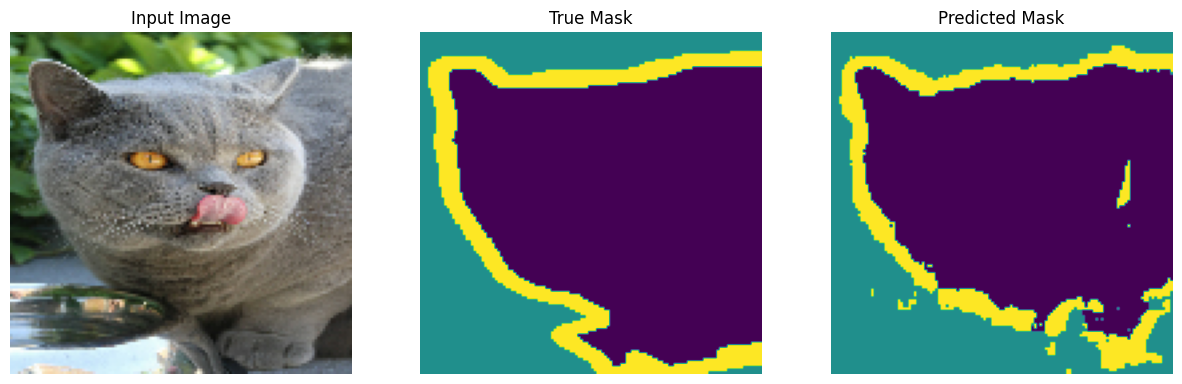

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 34ms/step


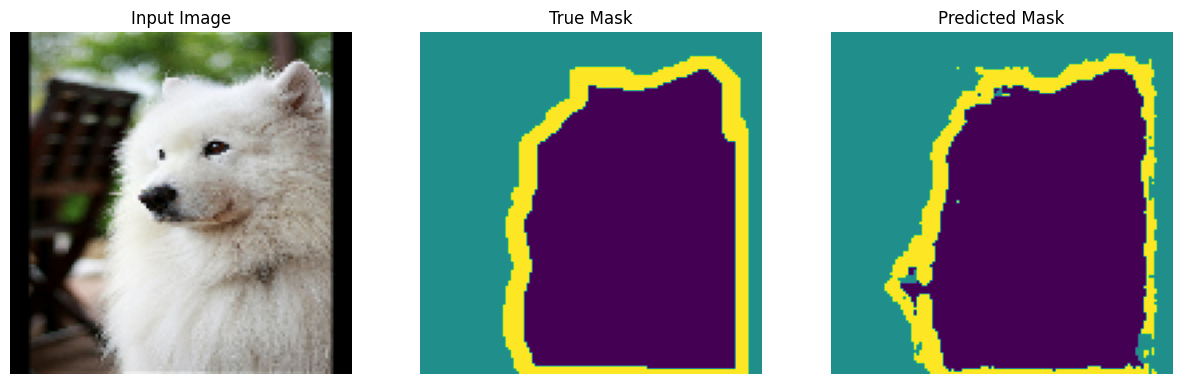

In [25]:
show_predictions(test_batches, 3)

## Optional: Imbalanced classes and class weights

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem. Refer to the [Classification on imbalanced data](../structured_data/imbalanced_data.ipynb) tutorial to learn more.

To [avoid ambiguity](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748), `Model.fit` does not support the `class_weight` argument for targets with 3+ dimensions.

In [26]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/20


 1/57 [..............................] - ETA: 1:37 - loss: 0.2690 - accuracy: 0.9283

 2/57 [>.............................] - ETA: 6s - loss: 0.2589 - accuracy: 0.9266  

 3/57 [>.............................] - ETA: 6s - loss: 0.2530 - accuracy: 0.9260

 4/57 [=>............................] - ETA: 5s - loss: 0.2520 - accuracy: 0.9242

 5/57 [=>............................] - ETA: 5s - loss: 0.2472 - accuracy: 0.9248

 6/57 [==>...........................] - ETA: 5s - loss: 0.2512 - accuracy: 0.9231

 7/57 [==>...........................] - ETA: 5s - loss: 0.2496 - accuracy: 0.9242

 8/57 [===>..........................] - ETA: 5s - loss: 0.2510 - accuracy: 0.9241

 9/57 [===>..........................] - ETA: 5s - loss: 0.2528 - accuracy: 0.9235

10/57 [====>.........................] - ETA: 5s - loss: 0.2537 - accuracy: 0.9230

11/57 [====>.........................] - ETA: 5s - loss: 0.2528 - accuracy: 0.9232

12/57 [=====>........................] - ETA: 4s - loss: 0.2525 - accuracy: 0.9229

13/57 [=====>........................] - ETA: 4s - loss: 0.2538 - accuracy: 0.9227

14/57 [======>.......................] - ETA: 4s - loss: 0.2552 - accuracy: 0.9225

15/57 [======>.......................] - ETA: 4s - loss: 0.2544 - accuracy: 0.9230

16/57 [=======>......................] - ETA: 4s - loss: 0.2562 - accuracy: 0.9228

17/57 [=======>......................] - ETA: 4s - loss: 0.2573 - accuracy: 0.9226

18/57 [========>.....................] - ETA: 4s - loss: 0.2584 - accuracy: 0.9222

19/57 [=========>....................] - ETA: 4s - loss: 0.2597 - accuracy: 0.9218

20/57 [=========>....................] - ETA: 4s - loss: 0.2622 - accuracy: 0.9213

21/57 [==========>...................] - ETA: 3s - loss: 0.2635 - accuracy: 0.9210

22/57 [==========>...................] - ETA: 3s - loss: 0.2643 - accuracy: 0.9210

23/57 [===========>..................] - ETA: 3s - loss: 0.2654 - accuracy: 0.9210

24/57 [===========>..................] - ETA: 3s - loss: 0.2654 - accuracy: 0.9211

25/57 [============>.................] - ETA: 3s - loss: 0.2657 - accuracy: 0.9210

26/57 [============>.................] - ETA: 3s - loss: 0.2659 - accuracy: 0.9208

27/57 [=============>................] - ETA: 3s - loss: 0.2673 - accuracy: 0.9206

28/57 [=============>................] - ETA: 3s - loss: 0.2679 - accuracy: 0.9205

29/57 [==============>...............] - ETA: 3s - loss: 0.2676 - accuracy: 0.9206

30/57 [==============>...............] - ETA: 2s - loss: 0.2674 - accuracy: 0.9205

31/57 [===============>..............] - ETA: 2s - loss: 0.2670 - accuracy: 0.9206

32/57 [===============>..............] - ETA: 2s - loss: 0.2665 - accuracy: 0.9208

33/57 [================>.............] - ETA: 2s - loss: 0.2667 - accuracy: 0.9207

34/57 [================>.............] - ETA: 2s - loss: 0.2664 - accuracy: 0.9208

35/57 [=================>............] - ETA: 2s - loss: 0.2660 - accuracy: 0.9209

36/57 [=================>............] - ETA: 2s - loss: 0.2662 - accuracy: 0.9208

37/57 [==================>...........] - ETA: 2s - loss: 0.2669 - accuracy: 0.9207

38/57 [===================>..........] - ETA: 2s - loss: 0.2675 - accuracy: 0.9205

39/57 [===================>..........] - ETA: 1s - loss: 0.2677 - accuracy: 0.9204

40/57 [====================>.........] - ETA: 1s - loss: 0.2673 - accuracy: 0.9203

41/57 [====================>.........] - ETA: 1s - loss: 0.2679 - accuracy: 0.9203

42/57 [=====================>........] - ETA: 1s - loss: 0.2673 - accuracy: 0.9205

43/57 [=====================>........] - ETA: 1s - loss: 0.2673 - accuracy: 0.9205

44/57 [======================>.......] - ETA: 1s - loss: 0.2678 - accuracy: 0.9202

45/57 [======================>.......] - ETA: 1s - loss: 0.2678 - accuracy: 0.9202

46/57 [=======================>......] - ETA: 1s - loss: 0.2683 - accuracy: 0.9200

47/57 [=======================>......] - ETA: 1s - loss: 0.2685 - accuracy: 0.9199

48/57 [========================>.....] - ETA: 0s - loss: 0.2684 - accuracy: 0.9200

49/57 [========================>.....] - ETA: 0s - loss: 0.2684 - accuracy: 0.9200

50/57 [=========================>....] - ETA: 0s - loss: 0.2690 - accuracy: 0.9198

51/57 [=========================>....] - ETA: 0s - loss: 0.2693 - accuracy: 0.9197

52/57 [==========================>...] - ETA: 0s - loss: 0.2693 - accuracy: 0.9196

53/57 [==========================>...] - ETA: 0s - loss: 0.2692 - accuracy: 0.9197

54/57 [===========================>..] - ETA: 0s - loss: 0.2691 - accuracy: 0.9198

55/57 [===========================>..] - ETA: 0s - loss: 0.2687 - accuracy: 0.9198

56/57 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.9198

57/57 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.9198

57/57 [==============================] - 8s 111ms/step - loss: 0.2683 - accuracy: 0.9198


Epoch 2/20


 1/57 [..............................] - ETA: 3s - loss: 0.2725 - accuracy: 0.9159

 2/57 [>.............................] - ETA: 6s - loss: 0.2593 - accuracy: 0.9223

 3/57 [>.............................] - ETA: 5s - loss: 0.2557 - accuracy: 0.9237

 4/57 [=>............................] - ETA: 5s - loss: 0.2537 - accuracy: 0.9236

 5/57 [=>............................] - ETA: 5s - loss: 0.2555 - accuracy: 0.9232

 6/57 [==>...........................] - ETA: 5s - loss: 0.2567 - accuracy: 0.9218

 7/57 [==>...........................] - ETA: 5s - loss: 0.2575 - accuracy: 0.9211

 8/57 [===>..........................] - ETA: 5s - loss: 0.2598 - accuracy: 0.9205

 9/57 [===>..........................] - ETA: 5s - loss: 0.2569 - accuracy: 0.9220

10/57 [====>.........................] - ETA: 5s - loss: 0.2561 - accuracy: 0.9225

11/57 [====>.........................] - ETA: 5s - loss: 0.2542 - accuracy: 0.9231

12/57 [=====>........................] - ETA: 4s - loss: 0.2579 - accuracy: 0.9223

13/57 [=====>........................] - ETA: 4s - loss: 0.2567 - accuracy: 0.9221

14/57 [======>.......................] - ETA: 4s - loss: 0.2591 - accuracy: 0.9213

15/57 [======>.......................] - ETA: 4s - loss: 0.2617 - accuracy: 0.9207

16/57 [=======>......................] - ETA: 4s - loss: 0.2610 - accuracy: 0.9211

17/57 [=======>......................] - ETA: 4s - loss: 0.2608 - accuracy: 0.9213

18/57 [========>.....................] - ETA: 4s - loss: 0.2632 - accuracy: 0.9209

19/57 [=========>....................] - ETA: 4s - loss: 0.2644 - accuracy: 0.9205

20/57 [=========>....................] - ETA: 4s - loss: 0.2651 - accuracy: 0.9202

21/57 [==========>...................] - ETA: 3s - loss: 0.2664 - accuracy: 0.9198

22/57 [==========>...................] - ETA: 3s - loss: 0.2661 - accuracy: 0.9200

23/57 [===========>..................] - ETA: 3s - loss: 0.2663 - accuracy: 0.9199

24/57 [===========>..................] - ETA: 3s - loss: 0.2663 - accuracy: 0.9199

25/57 [============>.................] - ETA: 3s - loss: 0.2672 - accuracy: 0.9198

26/57 [============>.................] - ETA: 3s - loss: 0.2661 - accuracy: 0.9202

27/57 [=============>................] - ETA: 3s - loss: 0.2652 - accuracy: 0.9204

28/57 [=============>................] - ETA: 3s - loss: 0.2653 - accuracy: 0.9203

29/57 [==============>...............] - ETA: 3s - loss: 0.2657 - accuracy: 0.9202

30/57 [==============>...............] - ETA: 2s - loss: 0.2649 - accuracy: 0.9204

31/57 [===============>..............] - ETA: 2s - loss: 0.2641 - accuracy: 0.9206

32/57 [===============>..............] - ETA: 2s - loss: 0.2636 - accuracy: 0.9207

33/57 [================>.............] - ETA: 2s - loss: 0.2636 - accuracy: 0.9208

34/57 [================>.............] - ETA: 2s - loss: 0.2626 - accuracy: 0.9210

35/57 [=================>............] - ETA: 2s - loss: 0.2634 - accuracy: 0.9207

36/57 [=================>............] - ETA: 2s - loss: 0.2643 - accuracy: 0.9205

37/57 [==================>...........] - ETA: 2s - loss: 0.2639 - accuracy: 0.9206

38/57 [===================>..........] - ETA: 2s - loss: 0.2632 - accuracy: 0.9209

39/57 [===================>..........] - ETA: 2s - loss: 0.2636 - accuracy: 0.9208

40/57 [====================>.........] - ETA: 1s - loss: 0.2632 - accuracy: 0.9209

41/57 [====================>.........] - ETA: 1s - loss: 0.2627 - accuracy: 0.9211

42/57 [=====================>........] - ETA: 1s - loss: 0.2623 - accuracy: 0.9211

43/57 [=====================>........] - ETA: 1s - loss: 0.2624 - accuracy: 0.9211

44/57 [======================>.......] - ETA: 1s - loss: 0.2628 - accuracy: 0.9209

45/57 [======================>.......] - ETA: 1s - loss: 0.2633 - accuracy: 0.9207

46/57 [=======================>......] - ETA: 1s - loss: 0.2636 - accuracy: 0.9207

47/57 [=======================>......] - ETA: 1s - loss: 0.2635 - accuracy: 0.9208

48/57 [========================>.....] - ETA: 0s - loss: 0.2633 - accuracy: 0.9209

49/57 [========================>.....] - ETA: 0s - loss: 0.2630 - accuracy: 0.9209

50/57 [=========================>....] - ETA: 0s - loss: 0.2629 - accuracy: 0.9209

51/57 [=========================>....] - ETA: 0s - loss: 0.2627 - accuracy: 0.9209

52/57 [==========================>...] - ETA: 0s - loss: 0.2629 - accuracy: 0.9208

53/57 [==========================>...] - ETA: 0s - loss: 0.2627 - accuracy: 0.9208

54/57 [===========================>..] - ETA: 0s - loss: 0.2626 - accuracy: 0.9209

55/57 [===========================>..] - ETA: 0s - loss: 0.2624 - accuracy: 0.9209

56/57 [============================>.] - ETA: 0s - loss: 0.2626 - accuracy: 0.9209

57/57 [==============================] - ETA: 0s - loss: 0.2627 - accuracy: 0.9209

57/57 [==============================] - 6s 111ms/step - loss: 0.2627 - accuracy: 0.9209


Epoch 3/20


 1/57 [..............................] - ETA: 5s - loss: 0.2430 - accuracy: 0.9286

 2/57 [>.............................] - ETA: 3s - loss: 0.2710 - accuracy: 0.9219

 3/57 [>.............................] - ETA: 4s - loss: 0.2580 - accuracy: 0.9226

 4/57 [=>............................] - ETA: 4s - loss: 0.2685 - accuracy: 0.9183

 5/57 [=>............................] - ETA: 5s - loss: 0.2715 - accuracy: 0.9176

 6/57 [==>...........................] - ETA: 5s - loss: 0.2744 - accuracy: 0.9177

 7/57 [==>...........................] - ETA: 5s - loss: 0.2727 - accuracy: 0.9189

 8/57 [===>..........................] - ETA: 5s - loss: 0.2738 - accuracy: 0.9188

 9/57 [===>..........................] - ETA: 5s - loss: 0.2702 - accuracy: 0.9192

10/57 [====>.........................] - ETA: 4s - loss: 0.2700 - accuracy: 0.9187

11/57 [====>.........................] - ETA: 4s - loss: 0.2684 - accuracy: 0.9191

12/57 [=====>........................] - ETA: 4s - loss: 0.2687 - accuracy: 0.9192

13/57 [=====>........................] - ETA: 4s - loss: 0.2672 - accuracy: 0.9193

14/57 [======>.......................] - ETA: 4s - loss: 0.2656 - accuracy: 0.9199

15/57 [======>.......................] - ETA: 4s - loss: 0.2639 - accuracy: 0.9205

16/57 [=======>......................] - ETA: 4s - loss: 0.2635 - accuracy: 0.9206

17/57 [=======>......................] - ETA: 4s - loss: 0.2627 - accuracy: 0.9209

18/57 [========>.....................] - ETA: 4s - loss: 0.2630 - accuracy: 0.9209

19/57 [=========>....................] - ETA: 4s - loss: 0.2626 - accuracy: 0.9210

20/57 [=========>....................] - ETA: 4s - loss: 0.2618 - accuracy: 0.9210

21/57 [==========>...................] - ETA: 3s - loss: 0.2606 - accuracy: 0.9213

22/57 [==========>...................] - ETA: 3s - loss: 0.2609 - accuracy: 0.9211

23/57 [===========>..................] - ETA: 3s - loss: 0.2616 - accuracy: 0.9211

24/57 [===========>..................] - ETA: 3s - loss: 0.2604 - accuracy: 0.9215

25/57 [============>.................] - ETA: 3s - loss: 0.2603 - accuracy: 0.9216

26/57 [============>.................] - ETA: 3s - loss: 0.2596 - accuracy: 0.9217

27/57 [=============>................] - ETA: 3s - loss: 0.2597 - accuracy: 0.9215

28/57 [=============>................] - ETA: 3s - loss: 0.2590 - accuracy: 0.9218

29/57 [==============>...............] - ETA: 3s - loss: 0.2585 - accuracy: 0.9220

30/57 [==============>...............] - ETA: 2s - loss: 0.2579 - accuracy: 0.9221

31/57 [===============>..............] - ETA: 2s - loss: 0.2574 - accuracy: 0.9222

32/57 [===============>..............] - ETA: 2s - loss: 0.2568 - accuracy: 0.9222

33/57 [================>.............] - ETA: 2s - loss: 0.2567 - accuracy: 0.9222

34/57 [================>.............] - ETA: 2s - loss: 0.2563 - accuracy: 0.9222

35/57 [=================>............] - ETA: 2s - loss: 0.2563 - accuracy: 0.9223

36/57 [=================>............] - ETA: 2s - loss: 0.2556 - accuracy: 0.9226

37/57 [==================>...........] - ETA: 2s - loss: 0.2553 - accuracy: 0.9227

38/57 [===================>..........] - ETA: 2s - loss: 0.2552 - accuracy: 0.9228

39/57 [===================>..........] - ETA: 1s - loss: 0.2549 - accuracy: 0.9227

40/57 [====================>.........] - ETA: 1s - loss: 0.2542 - accuracy: 0.9229

41/57 [====================>.........] - ETA: 1s - loss: 0.2540 - accuracy: 0.9228

42/57 [=====================>........] - ETA: 1s - loss: 0.2537 - accuracy: 0.9230

43/57 [=====================>........] - ETA: 1s - loss: 0.2538 - accuracy: 0.9229

44/57 [======================>.......] - ETA: 1s - loss: 0.2538 - accuracy: 0.9229

45/57 [======================>.......] - ETA: 1s - loss: 0.2535 - accuracy: 0.9230

46/57 [=======================>......] - ETA: 1s - loss: 0.2532 - accuracy: 0.9231

47/57 [=======================>......] - ETA: 1s - loss: 0.2527 - accuracy: 0.9232

48/57 [========================>.....] - ETA: 0s - loss: 0.2525 - accuracy: 0.9232

49/57 [========================>.....] - ETA: 0s - loss: 0.2524 - accuracy: 0.9232

50/57 [=========================>....] - ETA: 0s - loss: 0.2520 - accuracy: 0.9234

51/57 [=========================>....] - ETA: 0s - loss: 0.2520 - accuracy: 0.9233

52/57 [==========================>...] - ETA: 0s - loss: 0.2522 - accuracy: 0.9233

53/57 [==========================>...] - ETA: 0s - loss: 0.2523 - accuracy: 0.9233

54/57 [===========================>..] - ETA: 0s - loss: 0.2524 - accuracy: 0.9233

55/57 [===========================>..] - ETA: 0s - loss: 0.2521 - accuracy: 0.9233

56/57 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.9234

57/57 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.9235

57/57 [==============================] - 6s 111ms/step - loss: 0.2513 - accuracy: 0.9235


Epoch 4/20


 1/57 [..............................] - ETA: 5s - loss: 0.2501 - accuracy: 0.9256

 2/57 [>.............................] - ETA: 6s - loss: 0.2520 - accuracy: 0.9249

 3/57 [>.............................] - ETA: 4s - loss: 0.2495 - accuracy: 0.9251

 4/57 [=>............................] - ETA: 4s - loss: 0.2493 - accuracy: 0.9258

 5/57 [=>............................] - ETA: 5s - loss: 0.2498 - accuracy: 0.9250

 6/57 [==>...........................] - ETA: 5s - loss: 0.2465 - accuracy: 0.9254

 7/57 [==>...........................] - ETA: 5s - loss: 0.2433 - accuracy: 0.9255

 8/57 [===>..........................] - ETA: 5s - loss: 0.2446 - accuracy: 0.9248

 9/57 [===>..........................] - ETA: 5s - loss: 0.2442 - accuracy: 0.9250

10/57 [====>.........................] - ETA: 4s - loss: 0.2436 - accuracy: 0.9251

11/57 [====>.........................] - ETA: 4s - loss: 0.2429 - accuracy: 0.9258

12/57 [=====>........................] - ETA: 4s - loss: 0.2422 - accuracy: 0.9262

13/57 [=====>........................] - ETA: 4s - loss: 0.2429 - accuracy: 0.9259

14/57 [======>.......................] - ETA: 4s - loss: 0.2427 - accuracy: 0.9259

15/57 [======>.......................] - ETA: 4s - loss: 0.2407 - accuracy: 0.9264

16/57 [=======>......................] - ETA: 4s - loss: 0.2402 - accuracy: 0.9265

17/57 [=======>......................] - ETA: 4s - loss: 0.2389 - accuracy: 0.9270

18/57 [========>.....................] - ETA: 4s - loss: 0.2395 - accuracy: 0.9267

19/57 [=========>....................] - ETA: 4s - loss: 0.2384 - accuracy: 0.9269

20/57 [=========>....................] - ETA: 4s - loss: 0.2382 - accuracy: 0.9271

21/57 [==========>...................] - ETA: 3s - loss: 0.2380 - accuracy: 0.9271

22/57 [==========>...................] - ETA: 3s - loss: 0.2379 - accuracy: 0.9271

23/57 [===========>..................] - ETA: 3s - loss: 0.2386 - accuracy: 0.9268

24/57 [===========>..................] - ETA: 3s - loss: 0.2386 - accuracy: 0.9267

25/57 [============>.................] - ETA: 3s - loss: 0.2389 - accuracy: 0.9267

26/57 [============>.................] - ETA: 3s - loss: 0.2383 - accuracy: 0.9270

27/57 [=============>................] - ETA: 3s - loss: 0.2374 - accuracy: 0.9272

28/57 [=============>................] - ETA: 3s - loss: 0.2372 - accuracy: 0.9271

29/57 [==============>...............] - ETA: 3s - loss: 0.2372 - accuracy: 0.9271

30/57 [==============>...............] - ETA: 2s - loss: 0.2370 - accuracy: 0.9271

31/57 [===============>..............] - ETA: 2s - loss: 0.2368 - accuracy: 0.9272

32/57 [===============>..............] - ETA: 2s - loss: 0.2377 - accuracy: 0.9270

33/57 [================>.............] - ETA: 2s - loss: 0.2381 - accuracy: 0.9269

34/57 [================>.............] - ETA: 2s - loss: 0.2383 - accuracy: 0.9269

35/57 [=================>............] - ETA: 2s - loss: 0.2387 - accuracy: 0.9269

36/57 [=================>............] - ETA: 2s - loss: 0.2388 - accuracy: 0.9268

37/57 [==================>...........] - ETA: 2s - loss: 0.2392 - accuracy: 0.9267

38/57 [===================>..........] - ETA: 2s - loss: 0.2389 - accuracy: 0.9268

39/57 [===================>..........] - ETA: 1s - loss: 0.2388 - accuracy: 0.9267

40/57 [====================>.........] - ETA: 1s - loss: 0.2392 - accuracy: 0.9266

41/57 [====================>.........] - ETA: 1s - loss: 0.2390 - accuracy: 0.9267

42/57 [=====================>........] - ETA: 1s - loss: 0.2390 - accuracy: 0.9268

43/57 [=====================>........] - ETA: 1s - loss: 0.2386 - accuracy: 0.9268

44/57 [======================>.......] - ETA: 1s - loss: 0.2386 - accuracy: 0.9268

45/57 [======================>.......] - ETA: 1s - loss: 0.2388 - accuracy: 0.9267

46/57 [=======================>......] - ETA: 1s - loss: 0.2384 - accuracy: 0.9268

47/57 [=======================>......] - ETA: 1s - loss: 0.2380 - accuracy: 0.9270

48/57 [========================>.....] - ETA: 0s - loss: 0.2379 - accuracy: 0.9270

49/57 [========================>.....] - ETA: 0s - loss: 0.2375 - accuracy: 0.9271

50/57 [=========================>....] - ETA: 0s - loss: 0.2376 - accuracy: 0.9271

51/57 [=========================>....] - ETA: 0s - loss: 0.2374 - accuracy: 0.9271

52/57 [==========================>...] - ETA: 0s - loss: 0.2374 - accuracy: 0.9271

53/57 [==========================>...] - ETA: 0s - loss: 0.2374 - accuracy: 0.9270

54/57 [===========================>..] - ETA: 0s - loss: 0.2375 - accuracy: 0.9270

55/57 [===========================>..] - ETA: 0s - loss: 0.2371 - accuracy: 0.9271

56/57 [============================>.] - ETA: 0s - loss: 0.2375 - accuracy: 0.9270

57/57 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9271

57/57 [==============================] - 6s 111ms/step - loss: 0.2373 - accuracy: 0.9271


Epoch 5/20


 1/57 [..............................] - ETA: 5s - loss: 0.2520 - accuracy: 0.9243

 2/57 [>.............................] - ETA: 6s - loss: 0.2375 - accuracy: 0.9270

 3/57 [>.............................] - ETA: 6s - loss: 0.2324 - accuracy: 0.9275

 4/57 [=>............................] - ETA: 5s - loss: 0.2318 - accuracy: 0.9275

 5/57 [=>............................] - ETA: 5s - loss: 0.2307 - accuracy: 0.9282

 6/57 [==>...........................] - ETA: 5s - loss: 0.2321 - accuracy: 0.9281

 7/57 [==>...........................] - ETA: 5s - loss: 0.2300 - accuracy: 0.9287

 8/57 [===>..........................] - ETA: 5s - loss: 0.2304 - accuracy: 0.9290

 9/57 [===>..........................] - ETA: 5s - loss: 0.2293 - accuracy: 0.9294

10/57 [====>.........................] - ETA: 5s - loss: 0.2304 - accuracy: 0.9287

11/57 [====>.........................] - ETA: 4s - loss: 0.2298 - accuracy: 0.9288

12/57 [=====>........................] - ETA: 4s - loss: 0.2302 - accuracy: 0.9284

13/57 [=====>........................] - ETA: 4s - loss: 0.2301 - accuracy: 0.9285

14/57 [======>.......................] - ETA: 4s - loss: 0.2308 - accuracy: 0.9283

15/57 [======>.......................] - ETA: 4s - loss: 0.2306 - accuracy: 0.9285

16/57 [=======>......................] - ETA: 4s - loss: 0.2306 - accuracy: 0.9284

17/57 [=======>......................] - ETA: 4s - loss: 0.2305 - accuracy: 0.9285

18/57 [========>.....................] - ETA: 4s - loss: 0.2307 - accuracy: 0.9284

19/57 [=========>....................] - ETA: 4s - loss: 0.2296 - accuracy: 0.9287

20/57 [=========>....................] - ETA: 4s - loss: 0.2292 - accuracy: 0.9288

21/57 [==========>...................] - ETA: 3s - loss: 0.2300 - accuracy: 0.9286

22/57 [==========>...................] - ETA: 3s - loss: 0.2291 - accuracy: 0.9291

23/57 [===========>..................] - ETA: 3s - loss: 0.2286 - accuracy: 0.9293

24/57 [===========>..................] - ETA: 3s - loss: 0.2282 - accuracy: 0.9293

25/57 [============>.................] - ETA: 3s - loss: 0.2280 - accuracy: 0.9292

26/57 [============>.................] - ETA: 3s - loss: 0.2271 - accuracy: 0.9294

27/57 [=============>................] - ETA: 3s - loss: 0.2271 - accuracy: 0.9294

28/57 [=============>................] - ETA: 3s - loss: 0.2276 - accuracy: 0.9293

29/57 [==============>...............] - ETA: 3s - loss: 0.2284 - accuracy: 0.9292

30/57 [==============>...............] - ETA: 2s - loss: 0.2281 - accuracy: 0.9293

31/57 [===============>..............] - ETA: 2s - loss: 0.2274 - accuracy: 0.9296

32/57 [===============>..............] - ETA: 2s - loss: 0.2280 - accuracy: 0.9295

33/57 [================>.............] - ETA: 2s - loss: 0.2281 - accuracy: 0.9293

34/57 [================>.............] - ETA: 2s - loss: 0.2277 - accuracy: 0.9294

35/57 [=================>............] - ETA: 2s - loss: 0.2280 - accuracy: 0.9293

36/57 [=================>............] - ETA: 2s - loss: 0.2277 - accuracy: 0.9293

37/57 [==================>...........] - ETA: 2s - loss: 0.2274 - accuracy: 0.9294

38/57 [===================>..........] - ETA: 2s - loss: 0.2272 - accuracy: 0.9296

39/57 [===================>..........] - ETA: 1s - loss: 0.2273 - accuracy: 0.9295

40/57 [====================>.........] - ETA: 1s - loss: 0.2272 - accuracy: 0.9296

41/57 [====================>.........] - ETA: 1s - loss: 0.2274 - accuracy: 0.9295

42/57 [=====================>........] - ETA: 1s - loss: 0.2280 - accuracy: 0.9293

43/57 [=====================>........] - ETA: 1s - loss: 0.2283 - accuracy: 0.9292

44/57 [======================>.......] - ETA: 1s - loss: 0.2283 - accuracy: 0.9292

45/57 [======================>.......] - ETA: 1s - loss: 0.2283 - accuracy: 0.9292

46/57 [=======================>......] - ETA: 1s - loss: 0.2283 - accuracy: 0.9293

47/57 [=======================>......] - ETA: 1s - loss: 0.2282 - accuracy: 0.9293

48/57 [========================>.....] - ETA: 0s - loss: 0.2280 - accuracy: 0.9294

49/57 [========================>.....] - ETA: 0s - loss: 0.2278 - accuracy: 0.9294

50/57 [=========================>....] - ETA: 0s - loss: 0.2275 - accuracy: 0.9294

51/57 [=========================>....] - ETA: 0s - loss: 0.2274 - accuracy: 0.9294

52/57 [==========================>...] - ETA: 0s - loss: 0.2274 - accuracy: 0.9295

53/57 [==========================>...] - ETA: 0s - loss: 0.2276 - accuracy: 0.9294

54/57 [===========================>..] - ETA: 0s - loss: 0.2276 - accuracy: 0.9294

55/57 [===========================>..] - ETA: 0s - loss: 0.2275 - accuracy: 0.9295

56/57 [============================>.] - ETA: 0s - loss: 0.2276 - accuracy: 0.9294

57/57 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.9294

57/57 [==============================] - 6s 111ms/step - loss: 0.2276 - accuracy: 0.9294


Epoch 6/20


 1/57 [..............................] - ETA: 6s - loss: 0.2116 - accuracy: 0.9317

 2/57 [>.............................] - ETA: 5s - loss: 0.2203 - accuracy: 0.9298

 3/57 [>.............................] - ETA: 6s - loss: 0.2250 - accuracy: 0.9298

 4/57 [=>............................] - ETA: 5s - loss: 0.2276 - accuracy: 0.9293

 5/57 [=>............................] - ETA: 5s - loss: 0.2265 - accuracy: 0.9302

 6/57 [==>...........................] - ETA: 5s - loss: 0.2267 - accuracy: 0.9302

 7/57 [==>...........................] - ETA: 5s - loss: 0.2292 - accuracy: 0.9297

 8/57 [===>..........................] - ETA: 5s - loss: 0.2292 - accuracy: 0.9290

 9/57 [===>..........................] - ETA: 5s - loss: 0.2300 - accuracy: 0.9279

10/57 [====>.........................] - ETA: 4s - loss: 0.2293 - accuracy: 0.9280

11/57 [====>.........................] - ETA: 4s - loss: 0.2297 - accuracy: 0.9285

12/57 [=====>........................] - ETA: 4s - loss: 0.2292 - accuracy: 0.9292

13/57 [=====>........................] - ETA: 4s - loss: 0.2287 - accuracy: 0.9294

14/57 [======>.......................] - ETA: 4s - loss: 0.2276 - accuracy: 0.9298

15/57 [======>.......................] - ETA: 4s - loss: 0.2273 - accuracy: 0.9298

16/57 [=======>......................] - ETA: 4s - loss: 0.2273 - accuracy: 0.9296

17/57 [=======>......................] - ETA: 4s - loss: 0.2279 - accuracy: 0.9292

18/57 [========>.....................] - ETA: 4s - loss: 0.2286 - accuracy: 0.9288

19/57 [=========>....................] - ETA: 4s - loss: 0.2283 - accuracy: 0.9290

20/57 [=========>....................] - ETA: 4s - loss: 0.2272 - accuracy: 0.9294

21/57 [==========>...................] - ETA: 3s - loss: 0.2271 - accuracy: 0.9297

22/57 [==========>...................] - ETA: 3s - loss: 0.2270 - accuracy: 0.9298

23/57 [===========>..................] - ETA: 3s - loss: 0.2276 - accuracy: 0.9295

24/57 [===========>..................] - ETA: 3s - loss: 0.2265 - accuracy: 0.9297

25/57 [============>.................] - ETA: 3s - loss: 0.2254 - accuracy: 0.9299

26/57 [============>.................] - ETA: 3s - loss: 0.2248 - accuracy: 0.9301

27/57 [=============>................] - ETA: 3s - loss: 0.2242 - accuracy: 0.9302

28/57 [=============>................] - ETA: 3s - loss: 0.2245 - accuracy: 0.9300

29/57 [==============>...............] - ETA: 3s - loss: 0.2240 - accuracy: 0.9302

30/57 [==============>...............] - ETA: 2s - loss: 0.2241 - accuracy: 0.9302

31/57 [===============>..............] - ETA: 2s - loss: 0.2241 - accuracy: 0.9302

32/57 [===============>..............] - ETA: 2s - loss: 0.2242 - accuracy: 0.9301

33/57 [================>.............] - ETA: 2s - loss: 0.2238 - accuracy: 0.9302

34/57 [================>.............] - ETA: 2s - loss: 0.2249 - accuracy: 0.9299

35/57 [=================>............] - ETA: 2s - loss: 0.2257 - accuracy: 0.9297

36/57 [=================>............] - ETA: 2s - loss: 0.2252 - accuracy: 0.9299

37/57 [==================>...........] - ETA: 2s - loss: 0.2252 - accuracy: 0.9299

38/57 [===================>..........] - ETA: 2s - loss: 0.2252 - accuracy: 0.9299

39/57 [===================>..........] - ETA: 1s - loss: 0.2246 - accuracy: 0.9301

40/57 [====================>.........] - ETA: 1s - loss: 0.2248 - accuracy: 0.9301

41/57 [====================>.........] - ETA: 1s - loss: 0.2246 - accuracy: 0.9300

42/57 [=====================>........] - ETA: 1s - loss: 0.2246 - accuracy: 0.9300

43/57 [=====================>........] - ETA: 1s - loss: 0.2243 - accuracy: 0.9300

44/57 [======================>.......] - ETA: 1s - loss: 0.2249 - accuracy: 0.9300

45/57 [======================>.......] - ETA: 1s - loss: 0.2252 - accuracy: 0.9299

46/57 [=======================>......] - ETA: 1s - loss: 0.2254 - accuracy: 0.9299

47/57 [=======================>......] - ETA: 1s - loss: 0.2255 - accuracy: 0.9298

48/57 [========================>.....] - ETA: 0s - loss: 0.2253 - accuracy: 0.9299

49/57 [========================>.....] - ETA: 0s - loss: 0.2255 - accuracy: 0.9298

50/57 [=========================>....] - ETA: 0s - loss: 0.2250 - accuracy: 0.9300

51/57 [=========================>....] - ETA: 0s - loss: 0.2249 - accuracy: 0.9300

52/57 [==========================>...] - ETA: 0s - loss: 0.2247 - accuracy: 0.9301

53/57 [==========================>...] - ETA: 0s - loss: 0.2245 - accuracy: 0.9301

54/57 [===========================>..] - ETA: 0s - loss: 0.2241 - accuracy: 0.9302

55/57 [===========================>..] - ETA: 0s - loss: 0.2238 - accuracy: 0.9303

56/57 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.9304

57/57 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.9303

57/57 [==============================] - 6s 111ms/step - loss: 0.2236 - accuracy: 0.9303


Epoch 7/20


 1/57 [..............................] - ETA: 6s - loss: 0.2156 - accuracy: 0.9329

 2/57 [>.............................] - ETA: 6s - loss: 0.2127 - accuracy: 0.9334

 3/57 [>.............................] - ETA: 6s - loss: 0.2155 - accuracy: 0.9322

 4/57 [=>............................] - ETA: 5s - loss: 0.2157 - accuracy: 0.9322

 5/57 [=>............................] - ETA: 5s - loss: 0.2142 - accuracy: 0.9328

 6/57 [==>...........................] - ETA: 5s - loss: 0.2152 - accuracy: 0.9329

 7/57 [==>...........................] - ETA: 5s - loss: 0.2166 - accuracy: 0.9322

 8/57 [===>..........................] - ETA: 5s - loss: 0.2191 - accuracy: 0.9314

 9/57 [===>..........................] - ETA: 5s - loss: 0.2193 - accuracy: 0.9310

10/57 [====>.........................] - ETA: 4s - loss: 0.2184 - accuracy: 0.9312

11/57 [====>.........................] - ETA: 4s - loss: 0.2194 - accuracy: 0.9313

12/57 [=====>........................] - ETA: 4s - loss: 0.2200 - accuracy: 0.9315

13/57 [=====>........................] - ETA: 4s - loss: 0.2212 - accuracy: 0.9314

14/57 [======>.......................] - ETA: 4s - loss: 0.2200 - accuracy: 0.9316

15/57 [======>.......................] - ETA: 4s - loss: 0.2195 - accuracy: 0.9316

16/57 [=======>......................] - ETA: 4s - loss: 0.2195 - accuracy: 0.9314

17/57 [=======>......................] - ETA: 4s - loss: 0.2200 - accuracy: 0.9312

18/57 [========>.....................] - ETA: 4s - loss: 0.2215 - accuracy: 0.9309

19/57 [=========>....................] - ETA: 4s - loss: 0.2210 - accuracy: 0.9310

20/57 [=========>....................] - ETA: 4s - loss: 0.2212 - accuracy: 0.9311

21/57 [==========>...................] - ETA: 3s - loss: 0.2220 - accuracy: 0.9310

22/57 [==========>...................] - ETA: 3s - loss: 0.2222 - accuracy: 0.9309

23/57 [===========>..................] - ETA: 3s - loss: 0.2220 - accuracy: 0.9308

24/57 [===========>..................] - ETA: 3s - loss: 0.2212 - accuracy: 0.9310

25/57 [============>.................] - ETA: 3s - loss: 0.2212 - accuracy: 0.9309

26/57 [============>.................] - ETA: 3s - loss: 0.2217 - accuracy: 0.9309

27/57 [=============>................] - ETA: 3s - loss: 0.2207 - accuracy: 0.9313

28/57 [=============>................] - ETA: 3s - loss: 0.2222 - accuracy: 0.9307

29/57 [==============>...............] - ETA: 3s - loss: 0.2229 - accuracy: 0.9305

30/57 [==============>...............] - ETA: 2s - loss: 0.2224 - accuracy: 0.9307

31/57 [===============>..............] - ETA: 2s - loss: 0.2221 - accuracy: 0.9307

32/57 [===============>..............] - ETA: 2s - loss: 0.2218 - accuracy: 0.9308

33/57 [================>.............] - ETA: 2s - loss: 0.2213 - accuracy: 0.9310

34/57 [================>.............] - ETA: 2s - loss: 0.2214 - accuracy: 0.9310

35/57 [=================>............] - ETA: 2s - loss: 0.2209 - accuracy: 0.9312

36/57 [=================>............] - ETA: 2s - loss: 0.2209 - accuracy: 0.9312

37/57 [==================>...........] - ETA: 2s - loss: 0.2207 - accuracy: 0.9311

38/57 [===================>..........] - ETA: 2s - loss: 0.2204 - accuracy: 0.9312

39/57 [===================>..........] - ETA: 1s - loss: 0.2206 - accuracy: 0.9311

40/57 [====================>.........] - ETA: 1s - loss: 0.2208 - accuracy: 0.9311

41/57 [====================>.........] - ETA: 1s - loss: 0.2203 - accuracy: 0.9313

42/57 [=====================>........] - ETA: 1s - loss: 0.2199 - accuracy: 0.9315

43/57 [=====================>........] - ETA: 1s - loss: 0.2195 - accuracy: 0.9316

44/57 [======================>.......] - ETA: 1s - loss: 0.2197 - accuracy: 0.9314

45/57 [======================>.......] - ETA: 1s - loss: 0.2205 - accuracy: 0.9312

46/57 [=======================>......] - ETA: 1s - loss: 0.2204 - accuracy: 0.9313

47/57 [=======================>......] - ETA: 1s - loss: 0.2207 - accuracy: 0.9312

48/57 [========================>.....] - ETA: 0s - loss: 0.2209 - accuracy: 0.9311

49/57 [========================>.....] - ETA: 0s - loss: 0.2209 - accuracy: 0.9312

50/57 [=========================>....] - ETA: 0s - loss: 0.2208 - accuracy: 0.9312

51/57 [=========================>....] - ETA: 0s - loss: 0.2210 - accuracy: 0.9311

52/57 [==========================>...] - ETA: 0s - loss: 0.2207 - accuracy: 0.9312

53/57 [==========================>...] - ETA: 0s - loss: 0.2204 - accuracy: 0.9313

54/57 [===========================>..] - ETA: 0s - loss: 0.2204 - accuracy: 0.9313

55/57 [===========================>..] - ETA: 0s - loss: 0.2203 - accuracy: 0.9313

56/57 [============================>.] - ETA: 0s - loss: 0.2202 - accuracy: 0.9313

57/57 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9314

57/57 [==============================] - 6s 111ms/step - loss: 0.2200 - accuracy: 0.9314


Epoch 8/20


 1/57 [..............................] - ETA: 6s - loss: 0.2450 - accuracy: 0.9265

 2/57 [>.............................] - ETA: 6s - loss: 0.2349 - accuracy: 0.9269

 3/57 [>.............................] - ETA: 6s - loss: 0.2404 - accuracy: 0.9273

 4/57 [=>............................] - ETA: 5s - loss: 0.2344 - accuracy: 0.9290

 5/57 [=>............................] - ETA: 5s - loss: 0.2301 - accuracy: 0.9301

 6/57 [==>...........................] - ETA: 5s - loss: 0.2343 - accuracy: 0.9286

 7/57 [==>...........................] - ETA: 5s - loss: 0.2354 - accuracy: 0.9283

 8/57 [===>..........................] - ETA: 5s - loss: 0.2332 - accuracy: 0.9287

 9/57 [===>..........................] - ETA: 5s - loss: 0.2304 - accuracy: 0.9293

10/57 [====>.........................] - ETA: 4s - loss: 0.2283 - accuracy: 0.9298

11/57 [====>.........................] - ETA: 4s - loss: 0.2269 - accuracy: 0.9302

12/57 [=====>........................] - ETA: 4s - loss: 0.2267 - accuracy: 0.9305

13/57 [=====>........................] - ETA: 4s - loss: 0.2261 - accuracy: 0.9302

14/57 [======>.......................] - ETA: 4s - loss: 0.2270 - accuracy: 0.9297

15/57 [======>.......................] - ETA: 4s - loss: 0.2266 - accuracy: 0.9297

16/57 [=======>......................] - ETA: 4s - loss: 0.2256 - accuracy: 0.9302

17/57 [=======>......................] - ETA: 4s - loss: 0.2246 - accuracy: 0.9306

18/57 [========>.....................] - ETA: 4s - loss: 0.2238 - accuracy: 0.9308

19/57 [=========>....................] - ETA: 4s - loss: 0.2232 - accuracy: 0.9308

20/57 [=========>....................] - ETA: 4s - loss: 0.2230 - accuracy: 0.9308

21/57 [==========>...................] - ETA: 3s - loss: 0.2220 - accuracy: 0.9309

22/57 [==========>...................] - ETA: 3s - loss: 0.2219 - accuracy: 0.9309

23/57 [===========>..................] - ETA: 3s - loss: 0.2216 - accuracy: 0.9309

24/57 [===========>..................] - ETA: 3s - loss: 0.2210 - accuracy: 0.9310

25/57 [============>.................] - ETA: 3s - loss: 0.2208 - accuracy: 0.9312

26/57 [============>.................] - ETA: 3s - loss: 0.2203 - accuracy: 0.9315

27/57 [=============>................] - ETA: 3s - loss: 0.2199 - accuracy: 0.9315

28/57 [=============>................] - ETA: 3s - loss: 0.2193 - accuracy: 0.9316

29/57 [==============>...............] - ETA: 3s - loss: 0.2189 - accuracy: 0.9317

30/57 [==============>...............] - ETA: 2s - loss: 0.2184 - accuracy: 0.9319

31/57 [===============>..............] - ETA: 2s - loss: 0.2181 - accuracy: 0.9320

32/57 [===============>..............] - ETA: 2s - loss: 0.2178 - accuracy: 0.9320

33/57 [================>.............] - ETA: 2s - loss: 0.2176 - accuracy: 0.9320

34/57 [================>.............] - ETA: 2s - loss: 0.2167 - accuracy: 0.9323

35/57 [=================>............] - ETA: 2s - loss: 0.2162 - accuracy: 0.9325

36/57 [=================>............] - ETA: 2s - loss: 0.2168 - accuracy: 0.9323

37/57 [==================>...........] - ETA: 2s - loss: 0.2167 - accuracy: 0.9323

38/57 [===================>..........] - ETA: 2s - loss: 0.2166 - accuracy: 0.9323

39/57 [===================>..........] - ETA: 1s - loss: 0.2165 - accuracy: 0.9323

40/57 [====================>.........] - ETA: 1s - loss: 0.2167 - accuracy: 0.9324

41/57 [====================>.........] - ETA: 1s - loss: 0.2165 - accuracy: 0.9324

42/57 [=====================>........] - ETA: 1s - loss: 0.2161 - accuracy: 0.9325

43/57 [=====================>........] - ETA: 1s - loss: 0.2155 - accuracy: 0.9327

44/57 [======================>.......] - ETA: 1s - loss: 0.2154 - accuracy: 0.9327

45/57 [======================>.......] - ETA: 1s - loss: 0.2151 - accuracy: 0.9328

46/57 [=======================>......] - ETA: 1s - loss: 0.2149 - accuracy: 0.9328

47/57 [=======================>......] - ETA: 1s - loss: 0.2148 - accuracy: 0.9329

48/57 [========================>.....] - ETA: 0s - loss: 0.2146 - accuracy: 0.9329

49/57 [========================>.....] - ETA: 0s - loss: 0.2147 - accuracy: 0.9329

50/57 [=========================>....] - ETA: 0s - loss: 0.2145 - accuracy: 0.9330

51/57 [=========================>....] - ETA: 0s - loss: 0.2147 - accuracy: 0.9329

52/57 [==========================>...] - ETA: 0s - loss: 0.2145 - accuracy: 0.9330

53/57 [==========================>...] - ETA: 0s - loss: 0.2144 - accuracy: 0.9329

54/57 [===========================>..] - ETA: 0s - loss: 0.2144 - accuracy: 0.9329

55/57 [===========================>..] - ETA: 0s - loss: 0.2140 - accuracy: 0.9330

56/57 [============================>.] - ETA: 0s - loss: 0.2140 - accuracy: 0.9330

57/57 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9330

57/57 [==============================] - 6s 111ms/step - loss: 0.2140 - accuracy: 0.9330


Epoch 9/20


 1/57 [..............................] - ETA: 6s - loss: 0.1999 - accuracy: 0.9376

 2/57 [>.............................] - ETA: 5s - loss: 0.1978 - accuracy: 0.9384

 3/57 [>.............................] - ETA: 6s - loss: 0.1997 - accuracy: 0.9381

 4/57 [=>............................] - ETA: 5s - loss: 0.2019 - accuracy: 0.9362

 5/57 [=>............................] - ETA: 5s - loss: 0.2006 - accuracy: 0.9366

 6/57 [==>...........................] - ETA: 5s - loss: 0.2013 - accuracy: 0.9358

 7/57 [==>...........................] - ETA: 5s - loss: 0.2032 - accuracy: 0.9351

 8/57 [===>..........................] - ETA: 5s - loss: 0.2039 - accuracy: 0.9351

 9/57 [===>..........................] - ETA: 5s - loss: 0.2045 - accuracy: 0.9350

10/57 [====>.........................] - ETA: 4s - loss: 0.2046 - accuracy: 0.9348

11/57 [====>.........................] - ETA: 4s - loss: 0.2052 - accuracy: 0.9346

12/57 [=====>........................] - ETA: 4s - loss: 0.2045 - accuracy: 0.9349

13/57 [=====>........................] - ETA: 4s - loss: 0.2034 - accuracy: 0.9354

14/57 [======>.......................] - ETA: 4s - loss: 0.2035 - accuracy: 0.9355

15/57 [======>.......................] - ETA: 4s - loss: 0.2035 - accuracy: 0.9356

16/57 [=======>......................] - ETA: 4s - loss: 0.2032 - accuracy: 0.9355

17/57 [=======>......................] - ETA: 4s - loss: 0.2026 - accuracy: 0.9356

18/57 [========>.....................] - ETA: 4s - loss: 0.2021 - accuracy: 0.9357

19/57 [=========>....................] - ETA: 4s - loss: 0.2018 - accuracy: 0.9359

20/57 [=========>....................] - ETA: 4s - loss: 0.2017 - accuracy: 0.9360

21/57 [==========>...................] - ETA: 3s - loss: 0.2009 - accuracy: 0.9363

22/57 [==========>...................] - ETA: 3s - loss: 0.2012 - accuracy: 0.9362

23/57 [===========>..................] - ETA: 3s - loss: 0.2014 - accuracy: 0.9361

24/57 [===========>..................] - ETA: 3s - loss: 0.2010 - accuracy: 0.9362

25/57 [============>.................] - ETA: 3s - loss: 0.2009 - accuracy: 0.9362

26/57 [============>.................] - ETA: 3s - loss: 0.2011 - accuracy: 0.9362

27/57 [=============>................] - ETA: 3s - loss: 0.2010 - accuracy: 0.9361

28/57 [=============>................] - ETA: 3s - loss: 0.2010 - accuracy: 0.9363

29/57 [==============>...............] - ETA: 3s - loss: 0.2011 - accuracy: 0.9363

30/57 [==============>...............] - ETA: 2s - loss: 0.2013 - accuracy: 0.9362

31/57 [===============>..............] - ETA: 2s - loss: 0.2008 - accuracy: 0.9364

32/57 [===============>..............] - ETA: 2s - loss: 0.2010 - accuracy: 0.9362

33/57 [================>.............] - ETA: 2s - loss: 0.2010 - accuracy: 0.9363

34/57 [================>.............] - ETA: 2s - loss: 0.2010 - accuracy: 0.9362

35/57 [=================>............] - ETA: 2s - loss: 0.2013 - accuracy: 0.9360

36/57 [=================>............] - ETA: 2s - loss: 0.2014 - accuracy: 0.9361

37/57 [==================>...........] - ETA: 2s - loss: 0.2014 - accuracy: 0.9362

38/57 [===================>..........] - ETA: 2s - loss: 0.2010 - accuracy: 0.9363

39/57 [===================>..........] - ETA: 1s - loss: 0.2013 - accuracy: 0.9362

40/57 [====================>.........] - ETA: 1s - loss: 0.2014 - accuracy: 0.9362

41/57 [====================>.........] - ETA: 1s - loss: 0.2012 - accuracy: 0.9362

42/57 [=====================>........] - ETA: 1s - loss: 0.2008 - accuracy: 0.9363

43/57 [=====================>........] - ETA: 1s - loss: 0.2008 - accuracy: 0.9363

44/57 [======================>.......] - ETA: 1s - loss: 0.2005 - accuracy: 0.9364

45/57 [======================>.......] - ETA: 1s - loss: 0.2001 - accuracy: 0.9366

46/57 [=======================>......] - ETA: 1s - loss: 0.2002 - accuracy: 0.9366

47/57 [=======================>......] - ETA: 1s - loss: 0.2004 - accuracy: 0.9365

48/57 [========================>.....] - ETA: 0s - loss: 0.2007 - accuracy: 0.9363

49/57 [========================>.....] - ETA: 0s - loss: 0.2003 - accuracy: 0.9364

50/57 [=========================>....] - ETA: 0s - loss: 0.2004 - accuracy: 0.9363

51/57 [=========================>....] - ETA: 0s - loss: 0.2005 - accuracy: 0.9364

52/57 [==========================>...] - ETA: 0s - loss: 0.2004 - accuracy: 0.9365

53/57 [==========================>...] - ETA: 0s - loss: 0.2003 - accuracy: 0.9366

54/57 [===========================>..] - ETA: 0s - loss: 0.2002 - accuracy: 0.9366

55/57 [===========================>..] - ETA: 0s - loss: 0.2002 - accuracy: 0.9365

56/57 [============================>.] - ETA: 0s - loss: 0.2002 - accuracy: 0.9364

57/57 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9364

57/57 [==============================] - 6s 111ms/step - loss: 0.2003 - accuracy: 0.9364


Epoch 10/20


 1/57 [..............................] - ETA: 6s - loss: 0.2057 - accuracy: 0.9359

 2/57 [>.............................] - ETA: 5s - loss: 0.2024 - accuracy: 0.9374

 3/57 [>.............................] - ETA: 5s - loss: 0.2006 - accuracy: 0.9377

 4/57 [=>............................] - ETA: 5s - loss: 0.2021 - accuracy: 0.9372

 5/57 [=>............................] - ETA: 5s - loss: 0.2029 - accuracy: 0.9364

 6/57 [==>...........................] - ETA: 5s - loss: 0.2018 - accuracy: 0.9364

 7/57 [==>...........................] - ETA: 5s - loss: 0.2029 - accuracy: 0.9361

 8/57 [===>..........................] - ETA: 5s - loss: 0.2020 - accuracy: 0.9366

 9/57 [===>..........................] - ETA: 5s - loss: 0.2023 - accuracy: 0.9365

10/57 [====>.........................] - ETA: 4s - loss: 0.2009 - accuracy: 0.9370

11/57 [====>.........................] - ETA: 4s - loss: 0.2014 - accuracy: 0.9368

12/57 [=====>........................] - ETA: 4s - loss: 0.2007 - accuracy: 0.9369

13/57 [=====>........................] - ETA: 4s - loss: 0.2013 - accuracy: 0.9366

14/57 [======>.......................] - ETA: 4s - loss: 0.2000 - accuracy: 0.9368

15/57 [======>.......................] - ETA: 4s - loss: 0.1989 - accuracy: 0.9372

16/57 [=======>......................] - ETA: 4s - loss: 0.1985 - accuracy: 0.9373

17/57 [=======>......................] - ETA: 4s - loss: 0.1974 - accuracy: 0.9379

18/57 [========>.....................] - ETA: 4s - loss: 0.1977 - accuracy: 0.9377

19/57 [=========>....................] - ETA: 4s - loss: 0.1977 - accuracy: 0.9376

20/57 [=========>....................] - ETA: 4s - loss: 0.1974 - accuracy: 0.9376

21/57 [==========>...................] - ETA: 3s - loss: 0.1971 - accuracy: 0.9376

22/57 [==========>...................] - ETA: 3s - loss: 0.1969 - accuracy: 0.9377

23/57 [===========>..................] - ETA: 3s - loss: 0.1965 - accuracy: 0.9378

24/57 [===========>..................] - ETA: 3s - loss: 0.1960 - accuracy: 0.9379

25/57 [============>.................] - ETA: 3s - loss: 0.1959 - accuracy: 0.9379

26/57 [============>.................] - ETA: 3s - loss: 0.1955 - accuracy: 0.9381

27/57 [=============>................] - ETA: 3s - loss: 0.1947 - accuracy: 0.9384

28/57 [=============>................] - ETA: 3s - loss: 0.1948 - accuracy: 0.9383

29/57 [==============>...............] - ETA: 3s - loss: 0.1944 - accuracy: 0.9384

30/57 [==============>...............] - ETA: 2s - loss: 0.1944 - accuracy: 0.9383

31/57 [===============>..............] - ETA: 2s - loss: 0.1952 - accuracy: 0.9381

32/57 [===============>..............] - ETA: 2s - loss: 0.1953 - accuracy: 0.9381

33/57 [================>.............] - ETA: 2s - loss: 0.1954 - accuracy: 0.9382

34/57 [================>.............] - ETA: 2s - loss: 0.1954 - accuracy: 0.9382

35/57 [=================>............] - ETA: 2s - loss: 0.1958 - accuracy: 0.9380

36/57 [=================>............] - ETA: 2s - loss: 0.1961 - accuracy: 0.9379

37/57 [==================>...........] - ETA: 2s - loss: 0.1960 - accuracy: 0.9379

38/57 [===================>..........] - ETA: 2s - loss: 0.1965 - accuracy: 0.9378

39/57 [===================>..........] - ETA: 1s - loss: 0.1961 - accuracy: 0.9379

40/57 [====================>.........] - ETA: 1s - loss: 0.1961 - accuracy: 0.9380

41/57 [====================>.........] - ETA: 1s - loss: 0.1959 - accuracy: 0.9380

42/57 [=====================>........] - ETA: 1s - loss: 0.1962 - accuracy: 0.9379

43/57 [=====================>........] - ETA: 1s - loss: 0.1959 - accuracy: 0.9380

44/57 [======================>.......] - ETA: 1s - loss: 0.1962 - accuracy: 0.9379

45/57 [======================>.......] - ETA: 1s - loss: 0.1963 - accuracy: 0.9378

46/57 [=======================>......] - ETA: 1s - loss: 0.1964 - accuracy: 0.9378

47/57 [=======================>......] - ETA: 1s - loss: 0.1961 - accuracy: 0.9379

48/57 [========================>.....] - ETA: 0s - loss: 0.1961 - accuracy: 0.9379

49/57 [========================>.....] - ETA: 0s - loss: 0.1958 - accuracy: 0.9380

50/57 [=========================>....] - ETA: 0s - loss: 0.1955 - accuracy: 0.9381

51/57 [=========================>....] - ETA: 0s - loss: 0.1954 - accuracy: 0.9381

52/57 [==========================>...] - ETA: 0s - loss: 0.1956 - accuracy: 0.9380

53/57 [==========================>...] - ETA: 0s - loss: 0.1954 - accuracy: 0.9381

54/57 [===========================>..] - ETA: 0s - loss: 0.1952 - accuracy: 0.9382

55/57 [===========================>..] - ETA: 0s - loss: 0.1952 - accuracy: 0.9381

56/57 [============================>.] - ETA: 0s - loss: 0.1951 - accuracy: 0.9382

57/57 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9380

57/57 [==============================] - 6s 110ms/step - loss: 0.1956 - accuracy: 0.9380


Epoch 11/20


 1/57 [..............................] - ETA: 6s - loss: 0.2005 - accuracy: 0.9357

 2/57 [>.............................] - ETA: 6s - loss: 0.2000 - accuracy: 0.9364

 3/57 [>.............................] - ETA: 6s - loss: 0.2006 - accuracy: 0.9359

 4/57 [=>............................] - ETA: 5s - loss: 0.2005 - accuracy: 0.9357

 5/57 [=>............................] - ETA: 5s - loss: 0.2001 - accuracy: 0.9358

 6/57 [==>...........................] - ETA: 5s - loss: 0.1991 - accuracy: 0.9363

 7/57 [==>...........................] - ETA: 5s - loss: 0.1974 - accuracy: 0.9371

 8/57 [===>..........................] - ETA: 5s - loss: 0.1941 - accuracy: 0.9382

 9/57 [===>..........................] - ETA: 5s - loss: 0.1948 - accuracy: 0.9379

10/57 [====>.........................] - ETA: 4s - loss: 0.1947 - accuracy: 0.9378

11/57 [====>.........................] - ETA: 4s - loss: 0.1957 - accuracy: 0.9375

12/57 [=====>........................] - ETA: 4s - loss: 0.1946 - accuracy: 0.9380

13/57 [=====>........................] - ETA: 4s - loss: 0.1943 - accuracy: 0.9381

14/57 [======>.......................] - ETA: 4s - loss: 0.1945 - accuracy: 0.9382

15/57 [======>.......................] - ETA: 4s - loss: 0.1935 - accuracy: 0.9386

16/57 [=======>......................] - ETA: 4s - loss: 0.1933 - accuracy: 0.9388

17/57 [=======>......................] - ETA: 4s - loss: 0.1935 - accuracy: 0.9387

18/57 [========>.....................] - ETA: 4s - loss: 0.1932 - accuracy: 0.9388

19/57 [=========>....................] - ETA: 4s - loss: 0.1928 - accuracy: 0.9388

20/57 [=========>....................] - ETA: 4s - loss: 0.1932 - accuracy: 0.9386

21/57 [==========>...................] - ETA: 3s - loss: 0.1933 - accuracy: 0.9386

22/57 [==========>...................] - ETA: 3s - loss: 0.1935 - accuracy: 0.9386

23/57 [===========>..................] - ETA: 3s - loss: 0.1935 - accuracy: 0.9387

24/57 [===========>..................] - ETA: 3s - loss: 0.1932 - accuracy: 0.9390

25/57 [============>.................] - ETA: 3s - loss: 0.1934 - accuracy: 0.9390

26/57 [============>.................] - ETA: 3s - loss: 0.1937 - accuracy: 0.9387

27/57 [=============>................] - ETA: 3s - loss: 0.1941 - accuracy: 0.9386

28/57 [=============>................] - ETA: 3s - loss: 0.1938 - accuracy: 0.9386

29/57 [==============>...............] - ETA: 3s - loss: 0.1940 - accuracy: 0.9386

30/57 [==============>...............] - ETA: 2s - loss: 0.1952 - accuracy: 0.9383

31/57 [===============>..............] - ETA: 2s - loss: 0.1952 - accuracy: 0.9382

32/57 [===============>..............] - ETA: 2s - loss: 0.1949 - accuracy: 0.9383

33/57 [================>.............] - ETA: 2s - loss: 0.1946 - accuracy: 0.9383

34/57 [================>.............] - ETA: 2s - loss: 0.1944 - accuracy: 0.9384

35/57 [=================>............] - ETA: 2s - loss: 0.1943 - accuracy: 0.9383

36/57 [=================>............] - ETA: 2s - loss: 0.1943 - accuracy: 0.9384

37/57 [==================>...........] - ETA: 2s - loss: 0.1942 - accuracy: 0.9385

38/57 [===================>..........] - ETA: 2s - loss: 0.1946 - accuracy: 0.9384

39/57 [===================>..........] - ETA: 1s - loss: 0.1942 - accuracy: 0.9385

40/57 [====================>.........] - ETA: 1s - loss: 0.1939 - accuracy: 0.9386

41/57 [====================>.........] - ETA: 1s - loss: 0.1938 - accuracy: 0.9385

42/57 [=====================>........] - ETA: 1s - loss: 0.1936 - accuracy: 0.9385

43/57 [=====================>........] - ETA: 1s - loss: 0.1936 - accuracy: 0.9385

44/57 [======================>.......] - ETA: 1s - loss: 0.1930 - accuracy: 0.9387

45/57 [======================>.......] - ETA: 1s - loss: 0.1932 - accuracy: 0.9386

46/57 [=======================>......] - ETA: 1s - loss: 0.1932 - accuracy: 0.9387

47/57 [=======================>......] - ETA: 1s - loss: 0.1928 - accuracy: 0.9388

48/57 [========================>.....] - ETA: 0s - loss: 0.1929 - accuracy: 0.9388

49/57 [========================>.....] - ETA: 0s - loss: 0.1928 - accuracy: 0.9387

50/57 [=========================>....] - ETA: 0s - loss: 0.1924 - accuracy: 0.9388

51/57 [=========================>....] - ETA: 0s - loss: 0.1925 - accuracy: 0.9388

52/57 [==========================>...] - ETA: 0s - loss: 0.1925 - accuracy: 0.9388

53/57 [==========================>...] - ETA: 0s - loss: 0.1922 - accuracy: 0.9389

54/57 [===========================>..] - ETA: 0s - loss: 0.1923 - accuracy: 0.9390

55/57 [===========================>..] - ETA: 0s - loss: 0.1923 - accuracy: 0.9390

56/57 [============================>.] - ETA: 0s - loss: 0.1925 - accuracy: 0.9389

57/57 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9388

57/57 [==============================] - 6s 110ms/step - loss: 0.1927 - accuracy: 0.9388


Epoch 12/20


 1/57 [..............................] - ETA: 6s - loss: 0.1812 - accuracy: 0.9408

 2/57 [>.............................] - ETA: 6s - loss: 0.1784 - accuracy: 0.9416

 3/57 [>.............................] - ETA: 6s - loss: 0.1861 - accuracy: 0.9398

 4/57 [=>............................] - ETA: 5s - loss: 0.1867 - accuracy: 0.9405

 5/57 [=>............................] - ETA: 5s - loss: 0.1877 - accuracy: 0.9405

 6/57 [==>...........................] - ETA: 5s - loss: 0.1873 - accuracy: 0.9408

 7/57 [==>...........................] - ETA: 5s - loss: 0.1865 - accuracy: 0.9406

 8/57 [===>..........................] - ETA: 5s - loss: 0.1860 - accuracy: 0.9407

 9/57 [===>..........................] - ETA: 5s - loss: 0.1877 - accuracy: 0.9399

10/57 [====>.........................] - ETA: 5s - loss: 0.1873 - accuracy: 0.9400

11/57 [====>.........................] - ETA: 4s - loss: 0.1874 - accuracy: 0.9401

12/57 [=====>........................] - ETA: 4s - loss: 0.1875 - accuracy: 0.9401

13/57 [=====>........................] - ETA: 4s - loss: 0.1886 - accuracy: 0.9396

14/57 [======>.......................] - ETA: 4s - loss: 0.1893 - accuracy: 0.9394

15/57 [======>.......................] - ETA: 4s - loss: 0.1889 - accuracy: 0.9395

16/57 [=======>......................] - ETA: 4s - loss: 0.1881 - accuracy: 0.9399

17/57 [=======>......................] - ETA: 4s - loss: 0.1880 - accuracy: 0.9399

18/57 [========>.....................] - ETA: 4s - loss: 0.1872 - accuracy: 0.9402

19/57 [=========>....................] - ETA: 4s - loss: 0.1873 - accuracy: 0.9400

20/57 [=========>....................] - ETA: 4s - loss: 0.1871 - accuracy: 0.9400

21/57 [==========>...................] - ETA: 3s - loss: 0.1868 - accuracy: 0.9401

22/57 [==========>...................] - ETA: 3s - loss: 0.1863 - accuracy: 0.9404

23/57 [===========>..................] - ETA: 3s - loss: 0.1864 - accuracy: 0.9405

24/57 [===========>..................] - ETA: 3s - loss: 0.1866 - accuracy: 0.9403

25/57 [============>.................] - ETA: 3s - loss: 0.1867 - accuracy: 0.9403

26/57 [============>.................] - ETA: 3s - loss: 0.1869 - accuracy: 0.9403

27/57 [=============>................] - ETA: 3s - loss: 0.1871 - accuracy: 0.9402

28/57 [=============>................] - ETA: 3s - loss: 0.1871 - accuracy: 0.9403

29/57 [==============>...............] - ETA: 3s - loss: 0.1872 - accuracy: 0.9403

30/57 [==============>...............] - ETA: 2s - loss: 0.1870 - accuracy: 0.9404

31/57 [===============>..............] - ETA: 2s - loss: 0.1872 - accuracy: 0.9403

32/57 [===============>..............] - ETA: 2s - loss: 0.1875 - accuracy: 0.9401

33/57 [================>.............] - ETA: 2s - loss: 0.1871 - accuracy: 0.9402

34/57 [================>.............] - ETA: 2s - loss: 0.1871 - accuracy: 0.9402

35/57 [=================>............] - ETA: 2s - loss: 0.1873 - accuracy: 0.9401

36/57 [=================>............] - ETA: 2s - loss: 0.1874 - accuracy: 0.9402

37/57 [==================>...........] - ETA: 2s - loss: 0.1872 - accuracy: 0.9403

38/57 [===================>..........] - ETA: 2s - loss: 0.1871 - accuracy: 0.9404

39/57 [===================>..........] - ETA: 1s - loss: 0.1872 - accuracy: 0.9403

40/57 [====================>.........] - ETA: 1s - loss: 0.1871 - accuracy: 0.9402

41/57 [====================>.........] - ETA: 1s - loss: 0.1870 - accuracy: 0.9402

42/57 [=====================>........] - ETA: 1s - loss: 0.1867 - accuracy: 0.9404

43/57 [=====================>........] - ETA: 1s - loss: 0.1868 - accuracy: 0.9403

44/57 [======================>.......] - ETA: 1s - loss: 0.1866 - accuracy: 0.9404

45/57 [======================>.......] - ETA: 1s - loss: 0.1864 - accuracy: 0.9405

46/57 [=======================>......] - ETA: 1s - loss: 0.1860 - accuracy: 0.9407

47/57 [=======================>......] - ETA: 1s - loss: 0.1858 - accuracy: 0.9407

48/57 [========================>.....] - ETA: 0s - loss: 0.1858 - accuracy: 0.9407

49/57 [========================>.....] - ETA: 0s - loss: 0.1858 - accuracy: 0.9407

50/57 [=========================>....] - ETA: 0s - loss: 0.1860 - accuracy: 0.9406

51/57 [=========================>....] - ETA: 0s - loss: 0.1860 - accuracy: 0.9406

52/57 [==========================>...] - ETA: 0s - loss: 0.1861 - accuracy: 0.9406

53/57 [==========================>...] - ETA: 0s - loss: 0.1861 - accuracy: 0.9407

54/57 [===========================>..] - ETA: 0s - loss: 0.1861 - accuracy: 0.9407

55/57 [===========================>..] - ETA: 0s - loss: 0.1858 - accuracy: 0.9407

56/57 [============================>.] - ETA: 0s - loss: 0.1858 - accuracy: 0.9406

57/57 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9406

57/57 [==============================] - 6s 111ms/step - loss: 0.1856 - accuracy: 0.9406


Epoch 13/20


 1/57 [..............................] - ETA: 6s - loss: 0.1789 - accuracy: 0.9417

 2/57 [>.............................] - ETA: 6s - loss: 0.1790 - accuracy: 0.9428

 3/57 [>.............................] - ETA: 6s - loss: 0.1772 - accuracy: 0.9448

 4/57 [=>............................] - ETA: 5s - loss: 0.1820 - accuracy: 0.9437

 5/57 [=>............................] - ETA: 5s - loss: 0.1790 - accuracy: 0.9446

 6/57 [==>...........................] - ETA: 5s - loss: 0.1827 - accuracy: 0.9427

 7/57 [==>...........................] - ETA: 5s - loss: 0.1812 - accuracy: 0.9424

 8/57 [===>..........................] - ETA: 5s - loss: 0.1828 - accuracy: 0.9413

 9/57 [===>..........................] - ETA: 5s - loss: 0.1831 - accuracy: 0.9411

10/57 [====>.........................] - ETA: 5s - loss: 0.1850 - accuracy: 0.9407

11/57 [====>.........................] - ETA: 5s - loss: 0.1852 - accuracy: 0.9409

12/57 [=====>........................] - ETA: 4s - loss: 0.1861 - accuracy: 0.9409

13/57 [=====>........................] - ETA: 4s - loss: 0.1852 - accuracy: 0.9411

14/57 [======>.......................] - ETA: 4s - loss: 0.1842 - accuracy: 0.9412

15/57 [======>.......................] - ETA: 4s - loss: 0.1844 - accuracy: 0.9408

16/57 [=======>......................] - ETA: 4s - loss: 0.1841 - accuracy: 0.9408

17/57 [=======>......................] - ETA: 4s - loss: 0.1844 - accuracy: 0.9408

18/57 [========>.....................] - ETA: 4s - loss: 0.1847 - accuracy: 0.9408

19/57 [=========>....................] - ETA: 4s - loss: 0.1841 - accuracy: 0.9412

20/57 [=========>....................] - ETA: 4s - loss: 0.1844 - accuracy: 0.9412

21/57 [==========>...................] - ETA: 3s - loss: 0.1846 - accuracy: 0.9410

22/57 [==========>...................] - ETA: 3s - loss: 0.1843 - accuracy: 0.9410

23/57 [===========>..................] - ETA: 3s - loss: 0.1839 - accuracy: 0.9411

24/57 [===========>..................] - ETA: 3s - loss: 0.1839 - accuracy: 0.9411

25/57 [============>.................] - ETA: 3s - loss: 0.1832 - accuracy: 0.9413

26/57 [============>.................] - ETA: 3s - loss: 0.1824 - accuracy: 0.9416

27/57 [=============>................] - ETA: 3s - loss: 0.1820 - accuracy: 0.9418

28/57 [=============>................] - ETA: 3s - loss: 0.1815 - accuracy: 0.9420

29/57 [==============>...............] - ETA: 3s - loss: 0.1818 - accuracy: 0.9418

30/57 [==============>...............] - ETA: 2s - loss: 0.1817 - accuracy: 0.9418

31/57 [===============>..............] - ETA: 2s - loss: 0.1816 - accuracy: 0.9418

32/57 [===============>..............] - ETA: 2s - loss: 0.1816 - accuracy: 0.9418

33/57 [================>.............] - ETA: 2s - loss: 0.1816 - accuracy: 0.9418

34/57 [================>.............] - ETA: 2s - loss: 0.1814 - accuracy: 0.9419

35/57 [=================>............] - ETA: 2s - loss: 0.1811 - accuracy: 0.9420

36/57 [=================>............] - ETA: 2s - loss: 0.1809 - accuracy: 0.9421

37/57 [==================>...........] - ETA: 2s - loss: 0.1808 - accuracy: 0.9421

38/57 [===================>..........] - ETA: 2s - loss: 0.1810 - accuracy: 0.9421

39/57 [===================>..........] - ETA: 1s - loss: 0.1806 - accuracy: 0.9421

40/57 [====================>.........] - ETA: 1s - loss: 0.1805 - accuracy: 0.9421

41/57 [====================>.........] - ETA: 1s - loss: 0.1807 - accuracy: 0.9421

42/57 [=====================>........] - ETA: 1s - loss: 0.1807 - accuracy: 0.9421

43/57 [=====================>........] - ETA: 1s - loss: 0.1807 - accuracy: 0.9421

44/57 [======================>.......] - ETA: 1s - loss: 0.1808 - accuracy: 0.9422

45/57 [======================>.......] - ETA: 1s - loss: 0.1806 - accuracy: 0.9422

46/57 [=======================>......] - ETA: 1s - loss: 0.1808 - accuracy: 0.9421

47/57 [=======================>......] - ETA: 1s - loss: 0.1811 - accuracy: 0.9420

48/57 [========================>.....] - ETA: 0s - loss: 0.1809 - accuracy: 0.9421

49/57 [========================>.....] - ETA: 0s - loss: 0.1808 - accuracy: 0.9421

50/57 [=========================>....] - ETA: 0s - loss: 0.1808 - accuracy: 0.9421

51/57 [=========================>....] - ETA: 0s - loss: 0.1806 - accuracy: 0.9422

52/57 [==========================>...] - ETA: 0s - loss: 0.1809 - accuracy: 0.9421

53/57 [==========================>...] - ETA: 0s - loss: 0.1811 - accuracy: 0.9421

54/57 [===========================>..] - ETA: 0s - loss: 0.1812 - accuracy: 0.9420

55/57 [===========================>..] - ETA: 0s - loss: 0.1813 - accuracy: 0.9420

56/57 [============================>.] - ETA: 0s - loss: 0.1813 - accuracy: 0.9419

57/57 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9419

57/57 [==============================] - 6s 110ms/step - loss: 0.1815 - accuracy: 0.9419


Epoch 14/20


 1/57 [..............................] - ETA: 6s - loss: 0.1807 - accuracy: 0.9417

 2/57 [>.............................] - ETA: 6s - loss: 0.1783 - accuracy: 0.9434

 3/57 [>.............................] - ETA: 5s - loss: 0.1821 - accuracy: 0.9425

 4/57 [=>............................] - ETA: 5s - loss: 0.1859 - accuracy: 0.9413

 5/57 [=>............................] - ETA: 5s - loss: 0.1867 - accuracy: 0.9409

 6/57 [==>...........................] - ETA: 5s - loss: 0.1862 - accuracy: 0.9409

 7/57 [==>...........................] - ETA: 5s - loss: 0.1853 - accuracy: 0.9411

 8/57 [===>..........................] - ETA: 5s - loss: 0.1848 - accuracy: 0.9413

 9/57 [===>..........................] - ETA: 5s - loss: 0.1852 - accuracy: 0.9414

10/57 [====>.........................] - ETA: 5s - loss: 0.1851 - accuracy: 0.9415

11/57 [====>.........................] - ETA: 5s - loss: 0.1857 - accuracy: 0.9412

12/57 [=====>........................] - ETA: 5s - loss: 0.1848 - accuracy: 0.9412

13/57 [=====>........................] - ETA: 4s - loss: 0.1862 - accuracy: 0.9410

14/57 [======>.......................] - ETA: 4s - loss: 0.1859 - accuracy: 0.9409

15/57 [======>.......................] - ETA: 4s - loss: 0.1865 - accuracy: 0.9407

16/57 [=======>......................] - ETA: 4s - loss: 0.1861 - accuracy: 0.9410

17/57 [=======>......................] - ETA: 4s - loss: 0.1861 - accuracy: 0.9411

18/57 [========>.....................] - ETA: 4s - loss: 0.1858 - accuracy: 0.9411

19/57 [=========>....................] - ETA: 4s - loss: 0.1852 - accuracy: 0.9412

20/57 [=========>....................] - ETA: 4s - loss: 0.1857 - accuracy: 0.9410

21/57 [==========>...................] - ETA: 3s - loss: 0.1850 - accuracy: 0.9412

22/57 [==========>...................] - ETA: 3s - loss: 0.1844 - accuracy: 0.9413

23/57 [===========>..................] - ETA: 3s - loss: 0.1842 - accuracy: 0.9413

24/57 [===========>..................] - ETA: 3s - loss: 0.1842 - accuracy: 0.9413

25/57 [============>.................] - ETA: 3s - loss: 0.1839 - accuracy: 0.9415

26/57 [============>.................] - ETA: 3s - loss: 0.1837 - accuracy: 0.9416

27/57 [=============>................] - ETA: 3s - loss: 0.1843 - accuracy: 0.9415

28/57 [=============>................] - ETA: 3s - loss: 0.1840 - accuracy: 0.9415

29/57 [==============>...............] - ETA: 3s - loss: 0.1837 - accuracy: 0.9415

30/57 [==============>...............] - ETA: 2s - loss: 0.1839 - accuracy: 0.9414

31/57 [===============>..............] - ETA: 2s - loss: 0.1832 - accuracy: 0.9416

32/57 [===============>..............] - ETA: 2s - loss: 0.1833 - accuracy: 0.9416

33/57 [================>.............] - ETA: 2s - loss: 0.1834 - accuracy: 0.9416

34/57 [================>.............] - ETA: 2s - loss: 0.1834 - accuracy: 0.9417

35/57 [=================>............] - ETA: 2s - loss: 0.1828 - accuracy: 0.9419

36/57 [=================>............] - ETA: 2s - loss: 0.1827 - accuracy: 0.9418

37/57 [==================>...........] - ETA: 2s - loss: 0.1826 - accuracy: 0.9418

38/57 [===================>..........] - ETA: 2s - loss: 0.1825 - accuracy: 0.9418

39/57 [===================>..........] - ETA: 1s - loss: 0.1827 - accuracy: 0.9417

40/57 [====================>.........] - ETA: 1s - loss: 0.1828 - accuracy: 0.9417

41/57 [====================>.........] - ETA: 1s - loss: 0.1828 - accuracy: 0.9417

42/57 [=====================>........] - ETA: 1s - loss: 0.1825 - accuracy: 0.9418

43/57 [=====================>........] - ETA: 1s - loss: 0.1824 - accuracy: 0.9419

44/57 [======================>.......] - ETA: 1s - loss: 0.1821 - accuracy: 0.9420

45/57 [======================>.......] - ETA: 1s - loss: 0.1824 - accuracy: 0.9419

46/57 [=======================>......] - ETA: 1s - loss: 0.1825 - accuracy: 0.9418

47/57 [=======================>......] - ETA: 1s - loss: 0.1822 - accuracy: 0.9418

48/57 [========================>.....] - ETA: 0s - loss: 0.1822 - accuracy: 0.9418

49/57 [========================>.....] - ETA: 0s - loss: 0.1820 - accuracy: 0.9419

50/57 [=========================>....] - ETA: 0s - loss: 0.1817 - accuracy: 0.9420

51/57 [=========================>....] - ETA: 0s - loss: 0.1815 - accuracy: 0.9421

52/57 [==========================>...] - ETA: 0s - loss: 0.1813 - accuracy: 0.9422

53/57 [==========================>...] - ETA: 0s - loss: 0.1812 - accuracy: 0.9421

54/57 [===========================>..] - ETA: 0s - loss: 0.1809 - accuracy: 0.9422

55/57 [===========================>..] - ETA: 0s - loss: 0.1807 - accuracy: 0.9423

56/57 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9424

57/57 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9424

57/57 [==============================] - 6s 110ms/step - loss: 0.1801 - accuracy: 0.9424


Epoch 15/20


 1/57 [..............................] - ETA: 5s - loss: 0.1782 - accuracy: 0.9415

 2/57 [>.............................] - ETA: 6s - loss: 0.1746 - accuracy: 0.9435

 3/57 [>.............................] - ETA: 5s - loss: 0.1776 - accuracy: 0.9432

 4/57 [=>............................] - ETA: 5s - loss: 0.1763 - accuracy: 0.9438

 5/57 [=>............................] - ETA: 5s - loss: 0.1763 - accuracy: 0.9433

 6/57 [==>...........................] - ETA: 5s - loss: 0.1762 - accuracy: 0.9433

 7/57 [==>...........................] - ETA: 5s - loss: 0.1766 - accuracy: 0.9430

 8/57 [===>..........................] - ETA: 5s - loss: 0.1782 - accuracy: 0.9427

 9/57 [===>..........................] - ETA: 5s - loss: 0.1782 - accuracy: 0.9430

10/57 [====>.........................] - ETA: 5s - loss: 0.1777 - accuracy: 0.9431

11/57 [====>.........................] - ETA: 5s - loss: 0.1769 - accuracy: 0.9433

12/57 [=====>........................] - ETA: 5s - loss: 0.1776 - accuracy: 0.9429

13/57 [=====>........................] - ETA: 4s - loss: 0.1788 - accuracy: 0.9427

14/57 [======>.......................] - ETA: 4s - loss: 0.1785 - accuracy: 0.9427

15/57 [======>.......................] - ETA: 4s - loss: 0.1783 - accuracy: 0.9428

16/57 [=======>......................] - ETA: 4s - loss: 0.1781 - accuracy: 0.9430

17/57 [=======>......................] - ETA: 4s - loss: 0.1772 - accuracy: 0.9433

18/57 [========>.....................] - ETA: 4s - loss: 0.1765 - accuracy: 0.9433

19/57 [=========>....................] - ETA: 4s - loss: 0.1763 - accuracy: 0.9433

20/57 [=========>....................] - ETA: 4s - loss: 0.1762 - accuracy: 0.9433

21/57 [==========>...................] - ETA: 3s - loss: 0.1767 - accuracy: 0.9432

22/57 [==========>...................] - ETA: 3s - loss: 0.1760 - accuracy: 0.9435

23/57 [===========>..................] - ETA: 3s - loss: 0.1764 - accuracy: 0.9435

24/57 [===========>..................] - ETA: 3s - loss: 0.1766 - accuracy: 0.9434

25/57 [============>.................] - ETA: 3s - loss: 0.1769 - accuracy: 0.9433

26/57 [============>.................] - ETA: 3s - loss: 0.1769 - accuracy: 0.9432

27/57 [=============>................] - ETA: 3s - loss: 0.1767 - accuracy: 0.9433

28/57 [=============>................] - ETA: 3s - loss: 0.1765 - accuracy: 0.9435

29/57 [==============>...............] - ETA: 3s - loss: 0.1764 - accuracy: 0.9434

30/57 [==============>...............] - ETA: 2s - loss: 0.1768 - accuracy: 0.9434

31/57 [===============>..............] - ETA: 2s - loss: 0.1764 - accuracy: 0.9435

32/57 [===============>..............] - ETA: 2s - loss: 0.1759 - accuracy: 0.9436

33/57 [================>.............] - ETA: 2s - loss: 0.1758 - accuracy: 0.9436

34/57 [================>.............] - ETA: 2s - loss: 0.1757 - accuracy: 0.9437

35/57 [=================>............] - ETA: 2s - loss: 0.1755 - accuracy: 0.9438

36/57 [=================>............] - ETA: 2s - loss: 0.1755 - accuracy: 0.9437

37/57 [==================>...........] - ETA: 2s - loss: 0.1753 - accuracy: 0.9438

38/57 [===================>..........] - ETA: 2s - loss: 0.1750 - accuracy: 0.9439

39/57 [===================>..........] - ETA: 1s - loss: 0.1752 - accuracy: 0.9439

40/57 [====================>.........] - ETA: 1s - loss: 0.1752 - accuracy: 0.9439

41/57 [====================>.........] - ETA: 1s - loss: 0.1754 - accuracy: 0.9438

42/57 [=====================>........] - ETA: 1s - loss: 0.1751 - accuracy: 0.9439

43/57 [=====================>........] - ETA: 1s - loss: 0.1749 - accuracy: 0.9439

44/57 [======================>.......] - ETA: 1s - loss: 0.1748 - accuracy: 0.9439

45/57 [======================>.......] - ETA: 1s - loss: 0.1746 - accuracy: 0.9440

46/57 [=======================>......] - ETA: 1s - loss: 0.1747 - accuracy: 0.9440

47/57 [=======================>......] - ETA: 1s - loss: 0.1746 - accuracy: 0.9441

48/57 [========================>.....] - ETA: 0s - loss: 0.1745 - accuracy: 0.9440

49/57 [========================>.....] - ETA: 0s - loss: 0.1746 - accuracy: 0.9440

50/57 [=========================>....] - ETA: 0s - loss: 0.1745 - accuracy: 0.9440

51/57 [=========================>....] - ETA: 0s - loss: 0.1744 - accuracy: 0.9440

52/57 [==========================>...] - ETA: 0s - loss: 0.1745 - accuracy: 0.9440

53/57 [==========================>...] - ETA: 0s - loss: 0.1747 - accuracy: 0.9440

54/57 [===========================>..] - ETA: 0s - loss: 0.1745 - accuracy: 0.9441

55/57 [===========================>..] - ETA: 0s - loss: 0.1743 - accuracy: 0.9441

56/57 [============================>.] - ETA: 0s - loss: 0.1743 - accuracy: 0.9441

57/57 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.9440

57/57 [==============================] - 6s 110ms/step - loss: 0.1743 - accuracy: 0.9440


Epoch 16/20


 1/57 [..............................] - ETA: 5s - loss: 0.1711 - accuracy: 0.9429

 2/57 [>.............................] - ETA: 6s - loss: 0.1760 - accuracy: 0.9438

 3/57 [>.............................] - ETA: 5s - loss: 0.1726 - accuracy: 0.9456

 4/57 [=>............................] - ETA: 5s - loss: 0.1706 - accuracy: 0.9467

 5/57 [=>............................] - ETA: 5s - loss: 0.1709 - accuracy: 0.9460

 6/57 [==>...........................] - ETA: 5s - loss: 0.1720 - accuracy: 0.9454

 7/57 [==>...........................] - ETA: 5s - loss: 0.1725 - accuracy: 0.9451

 8/57 [===>..........................] - ETA: 5s - loss: 0.1714 - accuracy: 0.9453

 9/57 [===>..........................] - ETA: 5s - loss: 0.1728 - accuracy: 0.9444

10/57 [====>.........................] - ETA: 5s - loss: 0.1715 - accuracy: 0.9449

11/57 [====>.........................] - ETA: 5s - loss: 0.1719 - accuracy: 0.9448

12/57 [=====>........................] - ETA: 5s - loss: 0.1718 - accuracy: 0.9449

13/57 [=====>........................] - ETA: 4s - loss: 0.1712 - accuracy: 0.9452

14/57 [======>.......................] - ETA: 4s - loss: 0.1714 - accuracy: 0.9451

15/57 [======>.......................] - ETA: 4s - loss: 0.1726 - accuracy: 0.9448

16/57 [=======>......................] - ETA: 4s - loss: 0.1725 - accuracy: 0.9448

17/57 [=======>......................] - ETA: 4s - loss: 0.1749 - accuracy: 0.9444

18/57 [========>.....................] - ETA: 4s - loss: 0.1746 - accuracy: 0.9445

19/57 [=========>....................] - ETA: 4s - loss: 0.1753 - accuracy: 0.9442

20/57 [=========>....................] - ETA: 4s - loss: 0.1753 - accuracy: 0.9443

21/57 [==========>...................] - ETA: 3s - loss: 0.1758 - accuracy: 0.9442

22/57 [==========>...................] - ETA: 3s - loss: 0.1768 - accuracy: 0.9440

23/57 [===========>..................] - ETA: 3s - loss: 0.1768 - accuracy: 0.9439

24/57 [===========>..................] - ETA: 3s - loss: 0.1766 - accuracy: 0.9439

25/57 [============>.................] - ETA: 3s - loss: 0.1766 - accuracy: 0.9439

26/57 [============>.................] - ETA: 3s - loss: 0.1766 - accuracy: 0.9438

27/57 [=============>................] - ETA: 3s - loss: 0.1770 - accuracy: 0.9437

28/57 [=============>................] - ETA: 3s - loss: 0.1770 - accuracy: 0.9438

29/57 [==============>...............] - ETA: 3s - loss: 0.1776 - accuracy: 0.9437

30/57 [==============>...............] - ETA: 2s - loss: 0.1770 - accuracy: 0.9439

31/57 [===============>..............] - ETA: 2s - loss: 0.1770 - accuracy: 0.9439

32/57 [===============>..............] - ETA: 2s - loss: 0.1768 - accuracy: 0.9438

33/57 [================>.............] - ETA: 2s - loss: 0.1767 - accuracy: 0.9437

34/57 [================>.............] - ETA: 2s - loss: 0.1763 - accuracy: 0.9438

35/57 [=================>............] - ETA: 2s - loss: 0.1764 - accuracy: 0.9438

36/57 [=================>............] - ETA: 2s - loss: 0.1760 - accuracy: 0.9440

37/57 [==================>...........] - ETA: 2s - loss: 0.1760 - accuracy: 0.9440

38/57 [===================>..........] - ETA: 2s - loss: 0.1756 - accuracy: 0.9441

39/57 [===================>..........] - ETA: 1s - loss: 0.1754 - accuracy: 0.9441

40/57 [====================>.........] - ETA: 1s - loss: 0.1754 - accuracy: 0.9440

41/57 [====================>.........] - ETA: 1s - loss: 0.1753 - accuracy: 0.9440

42/57 [=====================>........] - ETA: 1s - loss: 0.1753 - accuracy: 0.9440

43/57 [=====================>........] - ETA: 1s - loss: 0.1751 - accuracy: 0.9441

44/57 [======================>.......] - ETA: 1s - loss: 0.1750 - accuracy: 0.9441

45/57 [======================>.......] - ETA: 1s - loss: 0.1747 - accuracy: 0.9442

46/57 [=======================>......] - ETA: 1s - loss: 0.1744 - accuracy: 0.9444

47/57 [=======================>......] - ETA: 1s - loss: 0.1741 - accuracy: 0.9445

48/57 [========================>.....] - ETA: 0s - loss: 0.1740 - accuracy: 0.9445

49/57 [========================>.....] - ETA: 0s - loss: 0.1741 - accuracy: 0.9444

50/57 [=========================>....] - ETA: 0s - loss: 0.1742 - accuracy: 0.9443

51/57 [=========================>....] - ETA: 0s - loss: 0.1739 - accuracy: 0.9444

52/57 [==========================>...] - ETA: 0s - loss: 0.1737 - accuracy: 0.9445

53/57 [==========================>...] - ETA: 0s - loss: 0.1736 - accuracy: 0.9445

54/57 [===========================>..] - ETA: 0s - loss: 0.1736 - accuracy: 0.9445

55/57 [===========================>..] - ETA: 0s - loss: 0.1733 - accuracy: 0.9446

56/57 [============================>.] - ETA: 0s - loss: 0.1733 - accuracy: 0.9446

57/57 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9446

57/57 [==============================] - 6s 110ms/step - loss: 0.1732 - accuracy: 0.9446


Epoch 17/20


 1/57 [..............................] - ETA: 6s - loss: 0.1690 - accuracy: 0.9451

 2/57 [>.............................] - ETA: 6s - loss: 0.1798 - accuracy: 0.9409

 3/57 [>.............................] - ETA: 6s - loss: 0.1801 - accuracy: 0.9419

 4/57 [=>............................] - ETA: 5s - loss: 0.1787 - accuracy: 0.9421

 5/57 [=>............................] - ETA: 5s - loss: 0.1814 - accuracy: 0.9415

 6/57 [==>...........................] - ETA: 5s - loss: 0.1792 - accuracy: 0.9426

 7/57 [==>...........................] - ETA: 5s - loss: 0.1798 - accuracy: 0.9427

 8/57 [===>..........................] - ETA: 5s - loss: 0.1788 - accuracy: 0.9429

 9/57 [===>..........................] - ETA: 5s - loss: 0.1799 - accuracy: 0.9424

10/57 [====>.........................] - ETA: 5s - loss: 0.1799 - accuracy: 0.9420

11/57 [====>.........................] - ETA: 5s - loss: 0.1792 - accuracy: 0.9421

12/57 [=====>........................] - ETA: 5s - loss: 0.1789 - accuracy: 0.9424

13/57 [=====>........................] - ETA: 4s - loss: 0.1784 - accuracy: 0.9428

14/57 [======>.......................] - ETA: 4s - loss: 0.1775 - accuracy: 0.9432

15/57 [======>.......................] - ETA: 4s - loss: 0.1777 - accuracy: 0.9431

16/57 [=======>......................] - ETA: 4s - loss: 0.1773 - accuracy: 0.9431

17/57 [=======>......................] - ETA: 4s - loss: 0.1769 - accuracy: 0.9430

18/57 [========>.....................] - ETA: 4s - loss: 0.1763 - accuracy: 0.9432

19/57 [=========>....................] - ETA: 4s - loss: 0.1769 - accuracy: 0.9430

20/57 [=========>....................] - ETA: 4s - loss: 0.1759 - accuracy: 0.9435

21/57 [==========>...................] - ETA: 3s - loss: 0.1752 - accuracy: 0.9438

22/57 [==========>...................] - ETA: 3s - loss: 0.1746 - accuracy: 0.9440

23/57 [===========>..................] - ETA: 3s - loss: 0.1741 - accuracy: 0.9441

24/57 [===========>..................] - ETA: 3s - loss: 0.1739 - accuracy: 0.9441

25/57 [============>.................] - ETA: 3s - loss: 0.1739 - accuracy: 0.9440

26/57 [============>.................] - ETA: 3s - loss: 0.1735 - accuracy: 0.9442

27/57 [=============>................] - ETA: 3s - loss: 0.1730 - accuracy: 0.9443

28/57 [=============>................] - ETA: 3s - loss: 0.1725 - accuracy: 0.9445

29/57 [==============>...............] - ETA: 3s - loss: 0.1725 - accuracy: 0.9445

30/57 [==============>...............] - ETA: 2s - loss: 0.1722 - accuracy: 0.9446

31/57 [===============>..............] - ETA: 2s - loss: 0.1718 - accuracy: 0.9446

32/57 [===============>..............] - ETA: 2s - loss: 0.1718 - accuracy: 0.9446

33/57 [================>.............] - ETA: 2s - loss: 0.1716 - accuracy: 0.9447

34/57 [================>.............] - ETA: 2s - loss: 0.1715 - accuracy: 0.9448

35/57 [=================>............] - ETA: 2s - loss: 0.1713 - accuracy: 0.9448

36/57 [=================>............] - ETA: 2s - loss: 0.1712 - accuracy: 0.9449

37/57 [==================>...........] - ETA: 2s - loss: 0.1712 - accuracy: 0.9449

38/57 [===================>..........] - ETA: 2s - loss: 0.1712 - accuracy: 0.9449

39/57 [===================>..........] - ETA: 1s - loss: 0.1709 - accuracy: 0.9449

40/57 [====================>.........] - ETA: 1s - loss: 0.1716 - accuracy: 0.9447

41/57 [====================>.........] - ETA: 1s - loss: 0.1714 - accuracy: 0.9448

42/57 [=====================>........] - ETA: 1s - loss: 0.1713 - accuracy: 0.9449

43/57 [=====================>........] - ETA: 1s - loss: 0.1709 - accuracy: 0.9450

44/57 [======================>.......] - ETA: 1s - loss: 0.1708 - accuracy: 0.9450

45/57 [======================>.......] - ETA: 1s - loss: 0.1714 - accuracy: 0.9448

46/57 [=======================>......] - ETA: 1s - loss: 0.1714 - accuracy: 0.9448

47/57 [=======================>......] - ETA: 1s - loss: 0.1714 - accuracy: 0.9448

48/57 [========================>.....] - ETA: 0s - loss: 0.1713 - accuracy: 0.9449

49/57 [========================>.....] - ETA: 0s - loss: 0.1710 - accuracy: 0.9450

50/57 [=========================>....] - ETA: 0s - loss: 0.1708 - accuracy: 0.9450

51/57 [=========================>....] - ETA: 0s - loss: 0.1705 - accuracy: 0.9451

52/57 [==========================>...] - ETA: 0s - loss: 0.1707 - accuracy: 0.9450

53/57 [==========================>...] - ETA: 0s - loss: 0.1706 - accuracy: 0.9451

54/57 [===========================>..] - ETA: 0s - loss: 0.1705 - accuracy: 0.9451

55/57 [===========================>..] - ETA: 0s - loss: 0.1706 - accuracy: 0.9451

56/57 [============================>.] - ETA: 0s - loss: 0.1704 - accuracy: 0.9452

57/57 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9452

57/57 [==============================] - 6s 110ms/step - loss: 0.1702 - accuracy: 0.9452


Epoch 18/20


 1/57 [..............................] - ETA: 6s - loss: 0.1614 - accuracy: 0.9478

 2/57 [>.............................] - ETA: 6s - loss: 0.1635 - accuracy: 0.9482

 3/57 [>.............................] - ETA: 5s - loss: 0.1644 - accuracy: 0.9483

 4/57 [=>............................] - ETA: 5s - loss: 0.1653 - accuracy: 0.9477

 5/57 [=>............................] - ETA: 5s - loss: 0.1645 - accuracy: 0.9478

 6/57 [==>...........................] - ETA: 5s - loss: 0.1633 - accuracy: 0.9479

 7/57 [==>...........................] - ETA: 5s - loss: 0.1646 - accuracy: 0.9475

 8/57 [===>..........................] - ETA: 5s - loss: 0.1641 - accuracy: 0.9473

 9/57 [===>..........................] - ETA: 5s - loss: 0.1645 - accuracy: 0.9475

10/57 [====>.........................] - ETA: 5s - loss: 0.1640 - accuracy: 0.9477

11/57 [====>.........................] - ETA: 5s - loss: 0.1646 - accuracy: 0.9475

12/57 [=====>........................] - ETA: 5s - loss: 0.1647 - accuracy: 0.9472

13/57 [=====>........................] - ETA: 4s - loss: 0.1652 - accuracy: 0.9470

14/57 [======>.......................] - ETA: 4s - loss: 0.1649 - accuracy: 0.9471

15/57 [======>.......................] - ETA: 4s - loss: 0.1649 - accuracy: 0.9473

16/57 [=======>......................] - ETA: 4s - loss: 0.1649 - accuracy: 0.9472

17/57 [=======>......................] - ETA: 4s - loss: 0.1651 - accuracy: 0.9471

18/57 [========>.....................] - ETA: 4s - loss: 0.1646 - accuracy: 0.9473

19/57 [=========>....................] - ETA: 4s - loss: 0.1644 - accuracy: 0.9474

20/57 [=========>....................] - ETA: 4s - loss: 0.1643 - accuracy: 0.9474

21/57 [==========>...................] - ETA: 3s - loss: 0.1642 - accuracy: 0.9474

22/57 [==========>...................] - ETA: 3s - loss: 0.1646 - accuracy: 0.9470

23/57 [===========>..................] - ETA: 3s - loss: 0.1643 - accuracy: 0.9470

24/57 [===========>..................] - ETA: 3s - loss: 0.1647 - accuracy: 0.9470

25/57 [============>.................] - ETA: 3s - loss: 0.1646 - accuracy: 0.9471

26/57 [============>.................] - ETA: 3s - loss: 0.1643 - accuracy: 0.9473

27/57 [=============>................] - ETA: 3s - loss: 0.1641 - accuracy: 0.9474

28/57 [=============>................] - ETA: 3s - loss: 0.1644 - accuracy: 0.9472

29/57 [==============>...............] - ETA: 3s - loss: 0.1644 - accuracy: 0.9472

30/57 [==============>...............] - ETA: 2s - loss: 0.1640 - accuracy: 0.9473

31/57 [===============>..............] - ETA: 2s - loss: 0.1639 - accuracy: 0.9473

32/57 [===============>..............] - ETA: 2s - loss: 0.1642 - accuracy: 0.9472

33/57 [================>.............] - ETA: 2s - loss: 0.1640 - accuracy: 0.9473

34/57 [================>.............] - ETA: 2s - loss: 0.1640 - accuracy: 0.9474

35/57 [=================>............] - ETA: 2s - loss: 0.1638 - accuracy: 0.9474

36/57 [=================>............] - ETA: 2s - loss: 0.1637 - accuracy: 0.9475

37/57 [==================>...........] - ETA: 2s - loss: 0.1639 - accuracy: 0.9473

38/57 [===================>..........] - ETA: 2s - loss: 0.1638 - accuracy: 0.9474

39/57 [===================>..........] - ETA: 1s - loss: 0.1640 - accuracy: 0.9473

40/57 [====================>.........] - ETA: 1s - loss: 0.1636 - accuracy: 0.9474

41/57 [====================>.........] - ETA: 1s - loss: 0.1638 - accuracy: 0.9473

42/57 [=====================>........] - ETA: 1s - loss: 0.1643 - accuracy: 0.9471

43/57 [=====================>........] - ETA: 1s - loss: 0.1642 - accuracy: 0.9472

44/57 [======================>.......] - ETA: 1s - loss: 0.1640 - accuracy: 0.9473

45/57 [======================>.......] - ETA: 1s - loss: 0.1640 - accuracy: 0.9473

46/57 [=======================>......] - ETA: 1s - loss: 0.1639 - accuracy: 0.9473

47/57 [=======================>......] - ETA: 1s - loss: 0.1639 - accuracy: 0.9473

48/57 [========================>.....] - ETA: 0s - loss: 0.1637 - accuracy: 0.9473

49/57 [========================>.....] - ETA: 0s - loss: 0.1637 - accuracy: 0.9473

50/57 [=========================>....] - ETA: 0s - loss: 0.1636 - accuracy: 0.9474

51/57 [=========================>....] - ETA: 0s - loss: 0.1634 - accuracy: 0.9475

52/57 [==========================>...] - ETA: 0s - loss: 0.1633 - accuracy: 0.9475

53/57 [==========================>...] - ETA: 0s - loss: 0.1632 - accuracy: 0.9475

54/57 [===========================>..] - ETA: 0s - loss: 0.1630 - accuracy: 0.9475

55/57 [===========================>..] - ETA: 0s - loss: 0.1630 - accuracy: 0.9475

56/57 [============================>.] - ETA: 0s - loss: 0.1629 - accuracy: 0.9476

57/57 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9475

57/57 [==============================] - 6s 110ms/step - loss: 0.1629 - accuracy: 0.9475


Epoch 19/20


 1/57 [..............................] - ETA: 6s - loss: 0.1519 - accuracy: 0.9524

 2/57 [>.............................] - ETA: 6s - loss: 0.1567 - accuracy: 0.9501

 3/57 [>.............................] - ETA: 5s - loss: 0.1566 - accuracy: 0.9500

 4/57 [=>............................] - ETA: 5s - loss: 0.1588 - accuracy: 0.9489

 5/57 [=>............................] - ETA: 5s - loss: 0.1580 - accuracy: 0.9487

 6/57 [==>...........................] - ETA: 5s - loss: 0.1583 - accuracy: 0.9489

 7/57 [==>...........................] - ETA: 5s - loss: 0.1577 - accuracy: 0.9495

 8/57 [===>..........................] - ETA: 5s - loss: 0.1572 - accuracy: 0.9497

 9/57 [===>..........................] - ETA: 5s - loss: 0.1567 - accuracy: 0.9496

10/57 [====>.........................] - ETA: 5s - loss: 0.1552 - accuracy: 0.9498

11/57 [====>.........................] - ETA: 5s - loss: 0.1555 - accuracy: 0.9495

12/57 [=====>........................] - ETA: 4s - loss: 0.1558 - accuracy: 0.9493

13/57 [=====>........................] - ETA: 4s - loss: 0.1566 - accuracy: 0.9493

14/57 [======>.......................] - ETA: 4s - loss: 0.1572 - accuracy: 0.9492

15/57 [======>.......................] - ETA: 4s - loss: 0.1575 - accuracy: 0.9491

16/57 [=======>......................] - ETA: 4s - loss: 0.1579 - accuracy: 0.9491

17/57 [=======>......................] - ETA: 4s - loss: 0.1584 - accuracy: 0.9489

18/57 [========>.....................] - ETA: 4s - loss: 0.1584 - accuracy: 0.9489

19/57 [=========>....................] - ETA: 4s - loss: 0.1583 - accuracy: 0.9489

20/57 [=========>....................] - ETA: 4s - loss: 0.1583 - accuracy: 0.9488

21/57 [==========>...................] - ETA: 3s - loss: 0.1583 - accuracy: 0.9487

22/57 [==========>...................] - ETA: 3s - loss: 0.1579 - accuracy: 0.9490

23/57 [===========>..................] - ETA: 3s - loss: 0.1578 - accuracy: 0.9490

24/57 [===========>..................] - ETA: 3s - loss: 0.1577 - accuracy: 0.9490

25/57 [============>.................] - ETA: 3s - loss: 0.1579 - accuracy: 0.9489

26/57 [============>.................] - ETA: 3s - loss: 0.1574 - accuracy: 0.9491

27/57 [=============>................] - ETA: 3s - loss: 0.1572 - accuracy: 0.9492

28/57 [=============>................] - ETA: 3s - loss: 0.1568 - accuracy: 0.9492

29/57 [==============>...............] - ETA: 3s - loss: 0.1564 - accuracy: 0.9494

30/57 [==============>...............] - ETA: 2s - loss: 0.1560 - accuracy: 0.9496

31/57 [===============>..............] - ETA: 2s - loss: 0.1560 - accuracy: 0.9495

32/57 [===============>..............] - ETA: 2s - loss: 0.1564 - accuracy: 0.9494

33/57 [================>.............] - ETA: 2s - loss: 0.1562 - accuracy: 0.9495

34/57 [================>.............] - ETA: 2s - loss: 0.1559 - accuracy: 0.9496

35/57 [=================>............] - ETA: 2s - loss: 0.1558 - accuracy: 0.9497

36/57 [=================>............] - ETA: 2s - loss: 0.1557 - accuracy: 0.9497

37/57 [==================>...........] - ETA: 2s - loss: 0.1556 - accuracy: 0.9497

38/57 [===================>..........] - ETA: 2s - loss: 0.1555 - accuracy: 0.9497

39/57 [===================>..........] - ETA: 1s - loss: 0.1555 - accuracy: 0.9497

40/57 [====================>.........] - ETA: 1s - loss: 0.1557 - accuracy: 0.9496

41/57 [====================>.........] - ETA: 1s - loss: 0.1555 - accuracy: 0.9497

42/57 [=====================>........] - ETA: 1s - loss: 0.1554 - accuracy: 0.9498

43/57 [=====================>........] - ETA: 1s - loss: 0.1553 - accuracy: 0.9499

44/57 [======================>.......] - ETA: 1s - loss: 0.1554 - accuracy: 0.9498

45/57 [======================>.......] - ETA: 1s - loss: 0.1554 - accuracy: 0.9498

46/57 [=======================>......] - ETA: 1s - loss: 0.1555 - accuracy: 0.9497

47/57 [=======================>......] - ETA: 1s - loss: 0.1555 - accuracy: 0.9497

48/57 [========================>.....] - ETA: 0s - loss: 0.1554 - accuracy: 0.9497

49/57 [========================>.....] - ETA: 0s - loss: 0.1553 - accuracy: 0.9498

50/57 [=========================>....] - ETA: 0s - loss: 0.1552 - accuracy: 0.9498

51/57 [=========================>....] - ETA: 0s - loss: 0.1554 - accuracy: 0.9498

52/57 [==========================>...] - ETA: 0s - loss: 0.1554 - accuracy: 0.9499

53/57 [==========================>...] - ETA: 0s - loss: 0.1553 - accuracy: 0.9499

54/57 [===========================>..] - ETA: 0s - loss: 0.1557 - accuracy: 0.9497

55/57 [===========================>..] - ETA: 0s - loss: 0.1556 - accuracy: 0.9497

56/57 [============================>.] - ETA: 0s - loss: 0.1554 - accuracy: 0.9497

57/57 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9496

57/57 [==============================] - 6s 110ms/step - loss: 0.1556 - accuracy: 0.9496


Epoch 20/20


 1/57 [..............................] - ETA: 5s - loss: 0.1545 - accuracy: 0.9518

 2/57 [>.............................] - ETA: 6s - loss: 0.1543 - accuracy: 0.9524

 3/57 [>.............................] - ETA: 6s - loss: 0.1512 - accuracy: 0.9537

 4/57 [=>............................] - ETA: 5s - loss: 0.1518 - accuracy: 0.9530

 5/57 [=>............................] - ETA: 5s - loss: 0.1505 - accuracy: 0.9530

 6/57 [==>...........................] - ETA: 5s - loss: 0.1531 - accuracy: 0.9513

 7/57 [==>...........................] - ETA: 5s - loss: 0.1520 - accuracy: 0.9512

 8/57 [===>..........................] - ETA: 5s - loss: 0.1514 - accuracy: 0.9511

 9/57 [===>..........................] - ETA: 5s - loss: 0.1535 - accuracy: 0.9506

10/57 [====>.........................] - ETA: 5s - loss: 0.1539 - accuracy: 0.9506

11/57 [====>.........................] - ETA: 5s - loss: 0.1541 - accuracy: 0.9507

12/57 [=====>........................] - ETA: 5s - loss: 0.1541 - accuracy: 0.9507

13/57 [=====>........................] - ETA: 4s - loss: 0.1545 - accuracy: 0.9504

14/57 [======>.......................] - ETA: 4s - loss: 0.1553 - accuracy: 0.9499

15/57 [======>.......................] - ETA: 4s - loss: 0.1547 - accuracy: 0.9501

16/57 [=======>......................] - ETA: 4s - loss: 0.1540 - accuracy: 0.9505

17/57 [=======>......................] - ETA: 4s - loss: 0.1538 - accuracy: 0.9505

18/57 [========>.....................] - ETA: 4s - loss: 0.1546 - accuracy: 0.9502

19/57 [=========>....................] - ETA: 4s - loss: 0.1545 - accuracy: 0.9503

20/57 [=========>....................] - ETA: 4s - loss: 0.1545 - accuracy: 0.9502

21/57 [==========>...................] - ETA: 3s - loss: 0.1549 - accuracy: 0.9499

22/57 [==========>...................] - ETA: 3s - loss: 0.1545 - accuracy: 0.9500

23/57 [===========>..................] - ETA: 3s - loss: 0.1542 - accuracy: 0.9502

24/57 [===========>..................] - ETA: 3s - loss: 0.1539 - accuracy: 0.9503

25/57 [============>.................] - ETA: 3s - loss: 0.1537 - accuracy: 0.9505

26/57 [============>.................] - ETA: 3s - loss: 0.1536 - accuracy: 0.9506

27/57 [=============>................] - ETA: 3s - loss: 0.1537 - accuracy: 0.9505

28/57 [=============>................] - ETA: 3s - loss: 0.1535 - accuracy: 0.9505

29/57 [==============>...............] - ETA: 3s - loss: 0.1533 - accuracy: 0.9504

30/57 [==============>...............] - ETA: 2s - loss: 0.1534 - accuracy: 0.9504

31/57 [===============>..............] - ETA: 2s - loss: 0.1536 - accuracy: 0.9504

32/57 [===============>..............] - ETA: 2s - loss: 0.1538 - accuracy: 0.9504

33/57 [================>.............] - ETA: 2s - loss: 0.1541 - accuracy: 0.9503

34/57 [================>.............] - ETA: 2s - loss: 0.1538 - accuracy: 0.9504

35/57 [=================>............] - ETA: 2s - loss: 0.1535 - accuracy: 0.9505

36/57 [=================>............] - ETA: 2s - loss: 0.1533 - accuracy: 0.9506

37/57 [==================>...........] - ETA: 2s - loss: 0.1535 - accuracy: 0.9504

38/57 [===================>..........] - ETA: 2s - loss: 0.1535 - accuracy: 0.9503

39/57 [===================>..........] - ETA: 1s - loss: 0.1533 - accuracy: 0.9505

40/57 [====================>.........] - ETA: 1s - loss: 0.1529 - accuracy: 0.9507

41/57 [====================>.........] - ETA: 1s - loss: 0.1531 - accuracy: 0.9506

42/57 [=====================>........] - ETA: 1s - loss: 0.1529 - accuracy: 0.9507

43/57 [=====================>........] - ETA: 1s - loss: 0.1529 - accuracy: 0.9507

44/57 [======================>.......] - ETA: 1s - loss: 0.1528 - accuracy: 0.9506

45/57 [======================>.......] - ETA: 1s - loss: 0.1527 - accuracy: 0.9507

46/57 [=======================>......] - ETA: 1s - loss: 0.1527 - accuracy: 0.9506

47/57 [=======================>......] - ETA: 1s - loss: 0.1525 - accuracy: 0.9507

48/57 [========================>.....] - ETA: 0s - loss: 0.1524 - accuracy: 0.9508

49/57 [========================>.....] - ETA: 0s - loss: 0.1522 - accuracy: 0.9509

50/57 [=========================>....] - ETA: 0s - loss: 0.1523 - accuracy: 0.9508

51/57 [=========================>....] - ETA: 0s - loss: 0.1520 - accuracy: 0.9509

52/57 [==========================>...] - ETA: 0s - loss: 0.1519 - accuracy: 0.9509

53/57 [==========================>...] - ETA: 0s - loss: 0.1518 - accuracy: 0.9509

54/57 [===========================>..] - ETA: 0s - loss: 0.1520 - accuracy: 0.9509

55/57 [===========================>..] - ETA: 0s - loss: 0.1520 - accuracy: 0.9509

56/57 [============================>.] - ETA: 0s - loss: 0.1520 - accuracy: 0.9509

57/57 [==============================] - ETA: 0s - loss: 0.1521 - accuracy: 0.9508

57/57 [==============================] - 6s 110ms/step - loss: 0.1521 - accuracy: 0.9508


Expected AssertionError: 


So, in this case you need to implement the weighting yourself. You'll do this using sample weights: In addition to `(data, label)` pairs, `Model.fit` also accepts `(data, label, sample_weight)` triples.

Keras `Model.fit` propagates the `sample_weight` to the losses and metrics, which also accept a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

In [27]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

So, to make sample weights for this tutorial, you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple where the `sample_weight` is a 1-channel image containing the class weight for each pixel.

The simplest possible implementation is to use the label as an index into a `class_weight` list:

In [28]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

The resulting dataset elements contain 3 images each:

In [29]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

Now, you can train a model on this weighted dataset:

In [30]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [31]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

 1/10 [==>...........................] - ETA: 38s - loss: 0.6954 - accuracy: 0.3872

 2/10 [=====>........................] - ETA: 1s - loss: 0.6247 - accuracy: 0.4212 

 3/10 [========>.....................] - ETA: 0s - loss: 0.5632 - accuracy: 0.4530

 4/10 [===========>..................] - ETA: 0s - loss: 0.5125 - accuracy: 0.4901

 5/10 [==============>...............] - ETA: 0s - loss: 0.4710 - accuracy: 0.5184

 6/10 [=================>............] - ETA: 0s - loss: 0.4377 - accuracy: 0.5454

 7/10 [====================>.........] - ETA: 0s - loss: 0.4105 - accuracy: 0.5696

 8/10 [=======================>......] - ETA: 0s - loss: 0.3862 - accuracy: 0.5935

 9/10 [==========================>...] - ETA: 0s - loss: 0.3652 - accuracy: 0.6157

10/10 [==============================] - ETA: 0s - loss: 0.3466 - accuracy: 0.6361

10/10 [==============================] - 5s 116ms/step - loss: 0.3466 - accuracy: 0.6361


## Next steps

Now that you have an understanding of what image segmentation is and how it works, you can try this tutorial out with different intermediate layer outputs, or even different pretrained models. You may also challenge yourself by trying out the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) image masking challenge hosted on Kaggle.

You may also want to see the [Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md) for another model you can retrain on your own data. Pretrained models are available on [TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection#optional).